In [1]:
%run dataFormating.ipynb

rmdfTestUsers read_csv success (1/3)
rmdf1522 read_csv success (2/3)
rmdf160 read_csv success (3/3)
gform read_csv success
gformFR read_csv success
temporalities set (user answer method)


IntProgress(value=0, max=1708)

profile info set


FloatProgress(value=0.0, max=621.0)

dataFormating.ipynb:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  "outputs": [


In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import scatter_matrix, parallel_coordinates

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from ipywidgets import FloatProgress
from IPython.display import display

from math import *

from scipy import stats

# Re-usable functions

In [3]:
# This function counts the number of occurences for each unique element in a list
def get_cnt(lVals):
    d = dict(zip(lVals, [0] * len(lVals)))
    for x in lVals:
        d[x] += 1
    return d

In [4]:
# This function fit a KMeans clustering model on the data, for each number of clusters in a specified range.
# It displays the silhouette analysis plot for each number of clusters and outputs the silhouette scores
# The higher the silhouette score, the more distinct the clusters are. In a good clustering, all clusters raise above the average
# Source: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
def tryKmeans(dataset, rangeNbClusters=[2, 3, 4, 5]):
    results = []
    
    # For each number of clusters
    for n_clusters in rangeNbClusters:
        # Create a subplot with 1 row and 1 column, make it possible to easily add plots in the function later if needed
        fig, ax = plt.subplots()
        fig.set_size_inches(12, 6)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(dataset) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(dataset)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(dataset, cluster_labels)
        
        # Save the silhouette score, the size of each cluster and the cluster assignement labels
        results.append([n_clusters, silhouette_avg, get_cnt(clusterer.labels_), clusterer.labels_])

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(dataset, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title("The silhouette plot for the various clusters.")
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()
        
    return results

In [5]:
# This function takes the initial data, result of tryKmeans and a chosen number of clusters
# It returns the label assignements of the sample
# If specified, it plots the parallel coordinates plot
# If specified, display only specified clusters
def detailsKmeans(initData, kmeansResult, nbClusters, displayParallelCoord = False, clusterLabels = [], clustersToDisplay = [], scale = False):
    # Add cluster assignement to the data
    assignements = list(kmeansResult.loc[kmeansResult["Number of clusters"] == nbClusters,'Label assignements'])[0]
    assignements = pd.DataFrame(data = assignements, columns = ["Index of cluster"], index = initData.index)
    
    # Displays
    if displayParallelCoord:
        nbGroups = ceil(len(initData.columns) / 8)
        print("Will split columns into {} groups".format(nbGroups))
        progressBar = FloatProgress(value = 0.0, min = 0.0, max = nbGroups)
        display(progressBar)
        # The data is split into several groups of columns for display
        for i in range(nbGroups):
            # Plot the data for the selected columns
            rangeMin = i * 8
            rangeMax = min(len(initData.columns), i * 8 + 9)
            scaledData = initData.iloc[:,rangeMin:rangeMax].copy()
            # Deal with scaling if specified
            if scale:
                col = scaledData.columns
                ind = scaledData.index
                scaledData = preprocessing.scale(scaledData)
                scaledData = pd.DataFrame(data = scaledData, columns=col, index=ind)
            labelledData = pd.concat([scaledData, assignements], axis = 1, join = "inner")
            # Select only some clusters if specified
            if len(clustersToDisplay) > 0:
                labelledData = labelledData.loc[labelledData["Index of cluster"].isin(clustersToDisplay), :]
            fig, ax = plt.subplots()
            fig.set_size_inches(17, 3)
            ax = parallel_coordinates(labelledData, 'Index of cluster')
            
            # Beautification
            plt.xticks(rotation=60)
            if len(clusterLabels) > 0:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles, clusterLabels)
            plt.show()
            
            progressBar.value += 1.0
    
    return assignements

In [6]:
# This function computes the frequency of True answers (scientific questions) or of each possible answer (non-scientific questions) for each cluster of a given clustering
# The specified question can be "allScience" (return table for all scientific questions) or the tag of any question
# If specific question and nbClusters = 2, print t-test between clusters
def freqByCluster(initData, kmeansResult, nbClusters, question) :
    # Add cluster assignement to the data
    assignements = list(kmeansResult.loc[kmeansResult["Number of clusters"] == nbClusters,'Label assignements'])[0]
    assignements = pd.DataFrame(data = assignements, columns = ["Index of cluster"], index = initData.index)
    
    # Get the size of the clusters
    sizeOfClusters = kmeansResult.loc[kmeansResult["Number of clusters"] == nbClusters,'Size of cluster'][0]
    
    # All scientific questions
    if question == "allScience":
        labelledData = initData.loc[:, "QGenotypePhenotype":"QDevicePbadRbsAraTer"]
        labelledData = pd.concat([labelledData, assignements], axis = 1, join = "inner")
        answersByCluster = pd.DataFrame()
        for cluster in range(nbClusters):
            nameOfCluster = "Cluster " + str(cluster)
            answersByCluster[nameOfCluster] = labelledData[labelledData["Index of cluster"] == cluster].sum()
            answersByCluster[nameOfCluster] = answersByCluster[nameOfCluster].divide(sizeOfClusters[cluster])
        answersByCluster.drop("Index of cluster", inplace=True)
    # For a specific question
    else:
        labelledData = pd.concat([initData, assignements], axis = 1, join = "inner")
        labelledData = labelledData.loc[:,[question, "Index of cluster"]]
        if (nbClusters == 2):
            group1 = labelledData[labelledData["Index of cluster"] == 0][question]
            group2 = labelledData[labelledData["Index of cluster"] == 1][question]
            print(stats.ttest_ind(group1, group2))
        answersByCluster = pd.DataFrame()
        for cluster in range(nbClusters):
            nameOfCluster = "Cluster " + str(cluster)
            frequencies = labelledData[labelledData["Index of cluster"] == cluster].groupby(question).count()
            frequencies = frequencies.divide(sizeOfClusters[cluster])
            frequencies = pd.DataFrame(data = frequencies["Index of cluster"].values, index = list(frequencies.index), columns = [nameOfCluster])
            answersByCluster = pd.concat([answersByCluster, frequencies], axis=1)
        answersByCluster.fillna(value = 0, inplace = True)
        
    return answersByCluster


# Can the data be clustered according to the answers given to the before questionnaire?

## If scientific questions are coded by answers

In [7]:
pd.options.display.max_columns = None
beforeForms["QEnjoyed"].unique()

array([-1, 3, 4, 2], dtype=object)

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


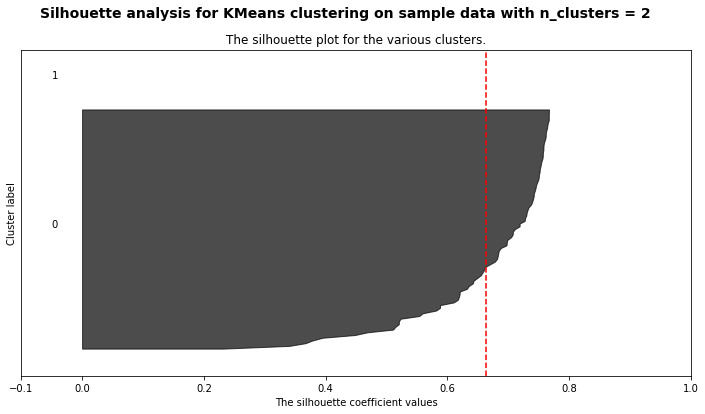

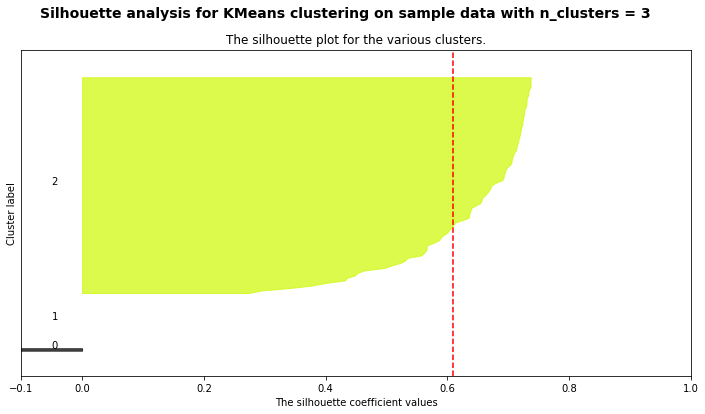

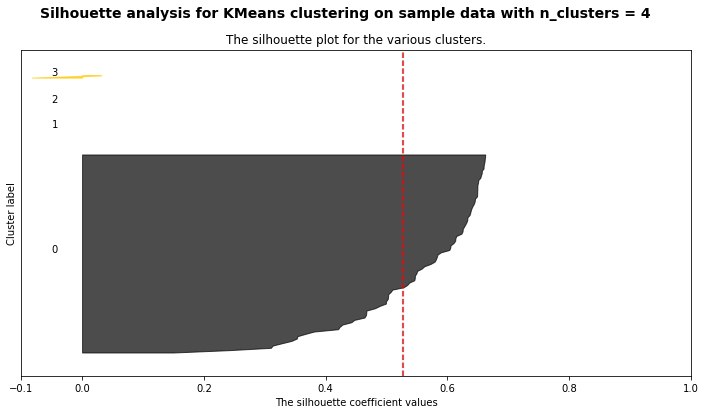

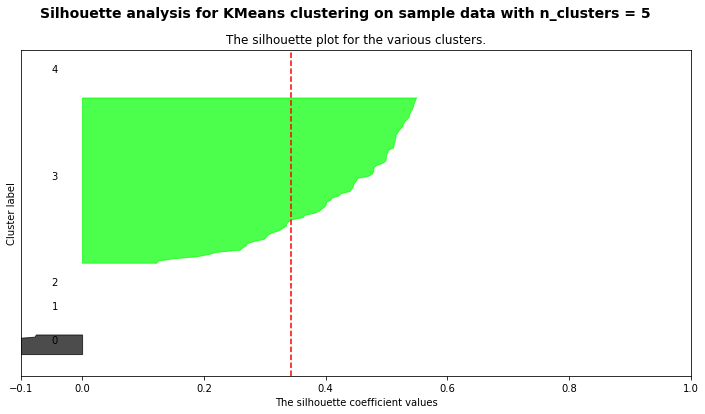

,Number of clusters,Average silhouette score,Size of cluster,Label assignements
0,2,0.663346,"{0: 89, 1: 1}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,3,0.609616,"{0: 2, 1: 1, 2: 87}","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
2,4,0.526914,"{0: 86, 1: 1, 2: 1, 3: 2}","[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,5,0.343690,"{0: 10, 1: 1, 2: 1, 3: 77, 4: 1}","[3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, ..."


In [8]:
# Convert DataFrame to matrix
beforeMat = beforeForms.as_matrix()
# Standardise data
beforeMat = preprocessing.scale(beforeMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeResults = tryKmeans(beforeMat)
# Format results as a DataFrame
beforeResults = pd.DataFrame(data=beforeResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeResults

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


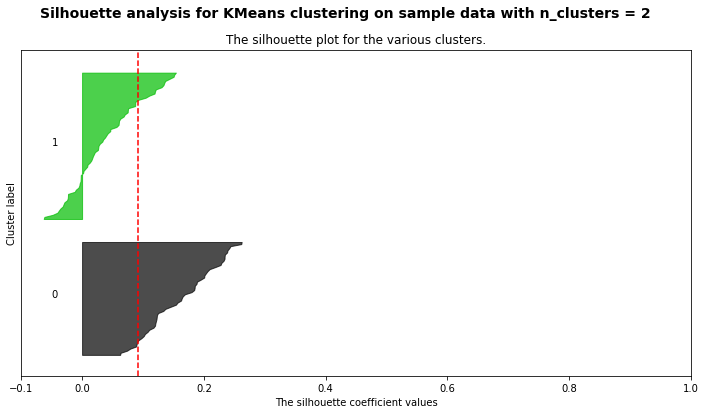

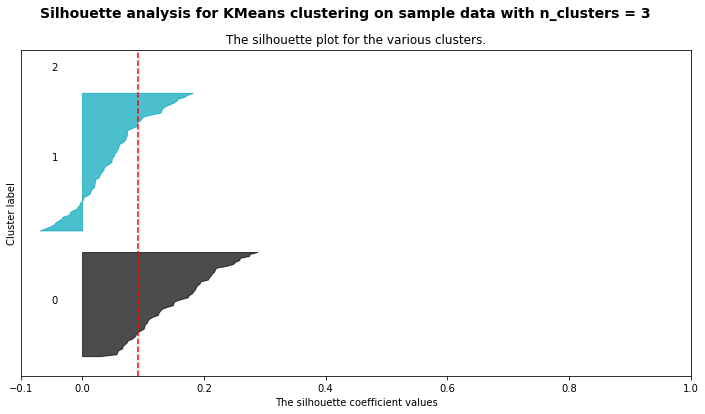

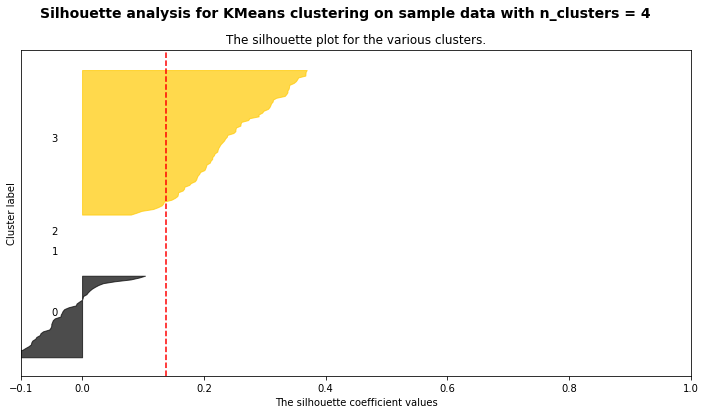

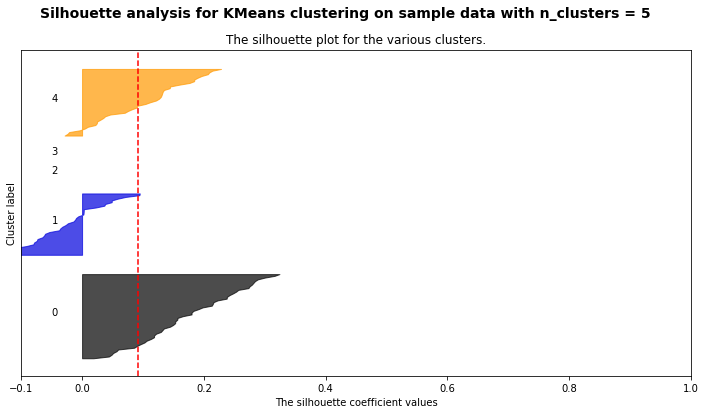

,Number of clusters,Average silhouette score,Size of cluster,Label assignements
0,2,0.092622,"{0: 55, 1: 71}","[1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, ..."
1,3,0.092694,"{0: 54, 1: 71, 2: 1}","[1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, ..."
2,4,0.138489,"{0: 45, 1: 1, 2: 1, 3: 79}","[3, 3, 3, 3, 0, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, ..."
3,5,0.091944,"{0: 49, 1: 36, 2: 1, 3: 1, 4: 39}","[1, 4, 0, 1, 4, 4, 4, 4, 1, 4, 4, 4, 0, 1, 0, ..."


In [9]:
# Convert DataFrame to matrix
beforeCorrectedMat = beforeCorrectedForms.as_matrix()
# Standardise data
beforeCorrectedMat = preprocessing.scale(beforeCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeCorrectedResults = tryKmeans(beforeCorrectedMat)
# Format results as a DataFrame
beforeCorrectedResults = pd.DataFrame(data=beforeCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeCorrectedResults

Conclusion: No interesting clustering (29/05/2018)

Will split columns into 6 groups


FloatProgress(value=0.0, max=6.0)

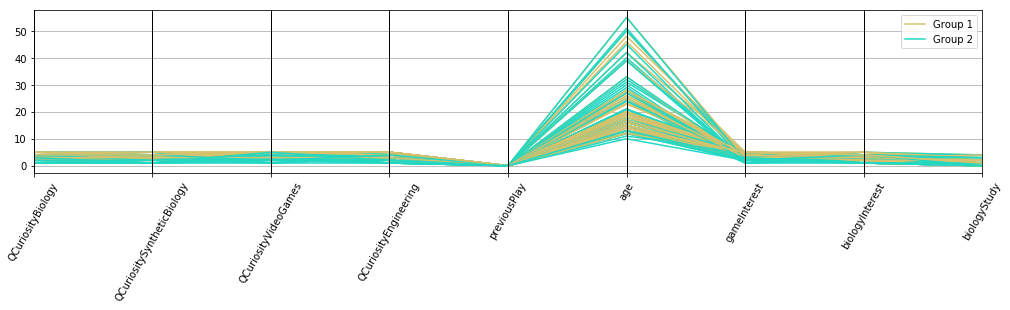

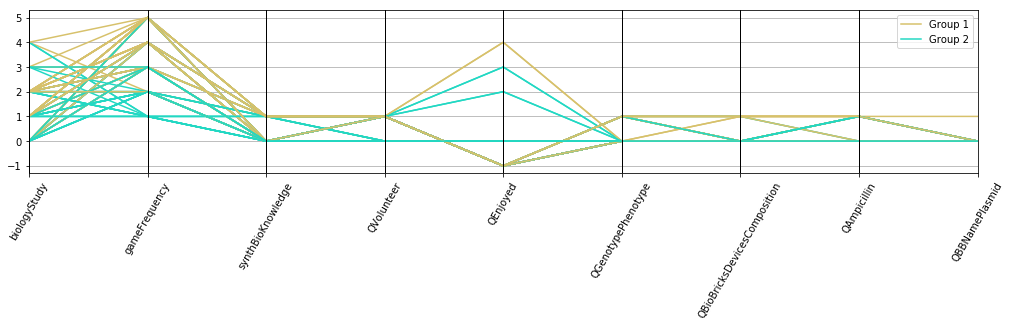

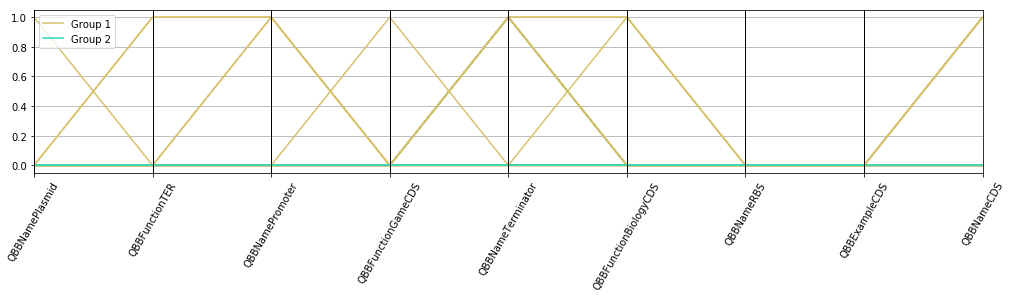

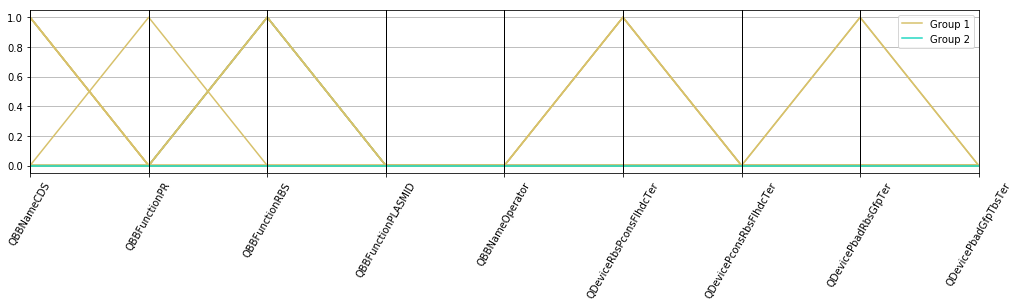

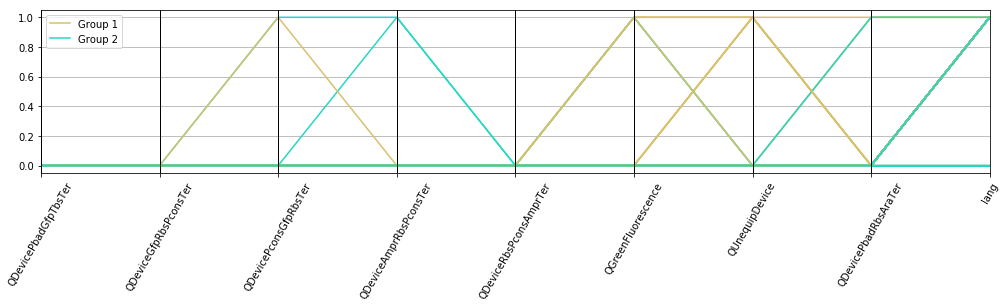

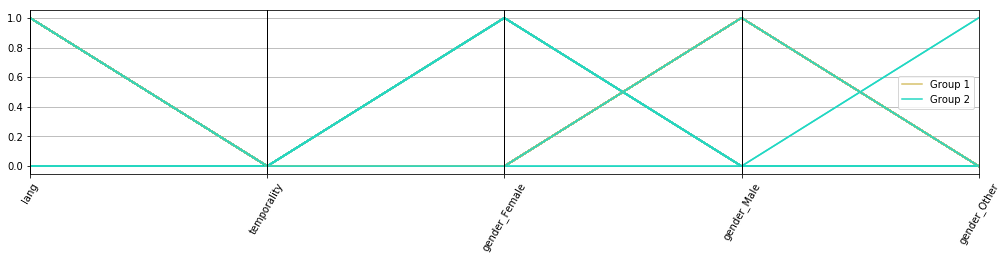

In [10]:
# Display parallel coordinates plot
assignements = detailsKmeans(beforeCorrectedForms, beforeCorrectedResults, 2, displayParallelCoord=True, clusterLabels=["Group 1", "Group 2"])

# Can the data be clustered according to the answers given to the after questionnaire?

## If scientific questions are coded by answers

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


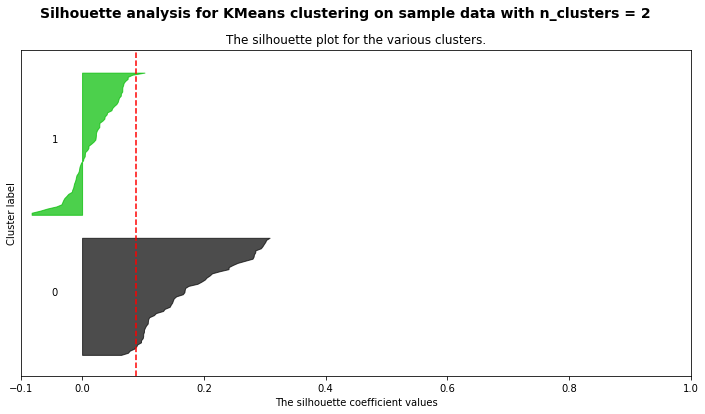

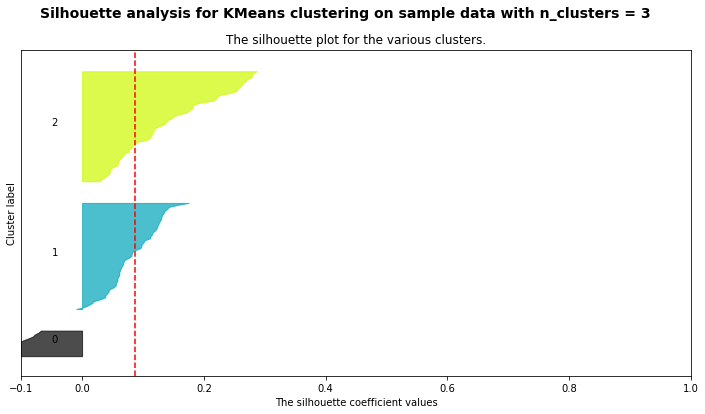

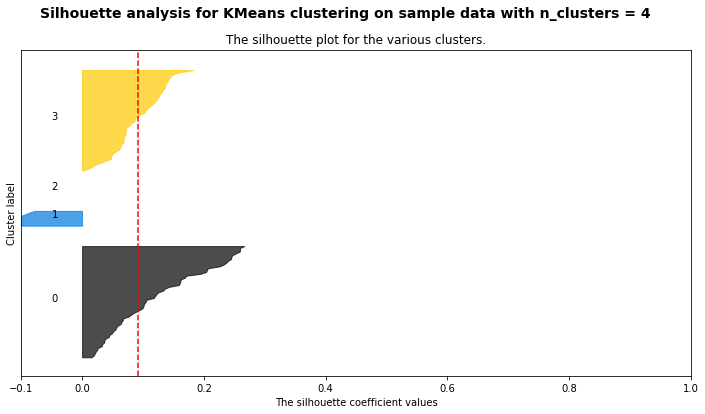

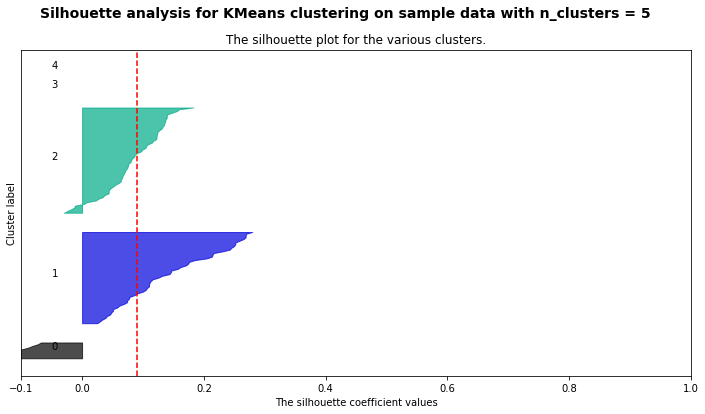

In [11]:
# Convert DataFrame to matrix
afterMat = afterForms.as_matrix()
# Standardise the data
afterMat = preprocessing.scale(afterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
afterResults = tryKmeans(afterMat)
# Format results as a DataFrame
afterResults = pd.DataFrame(data=afterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


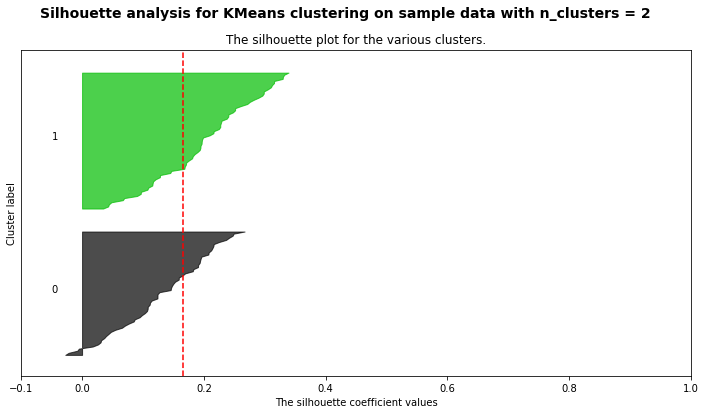

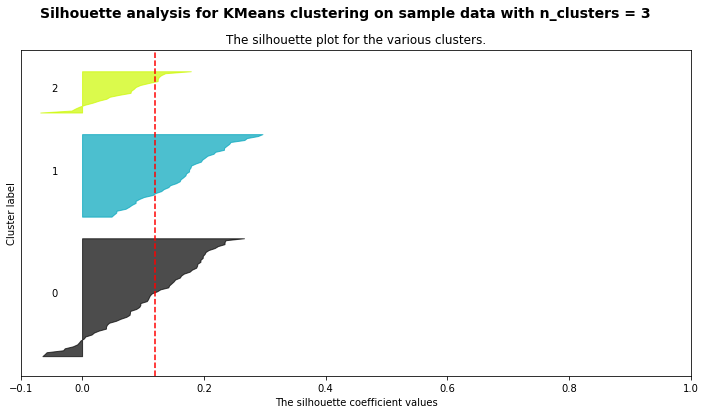

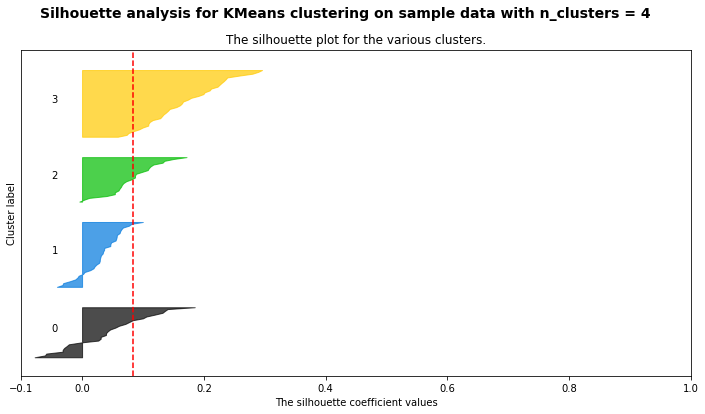

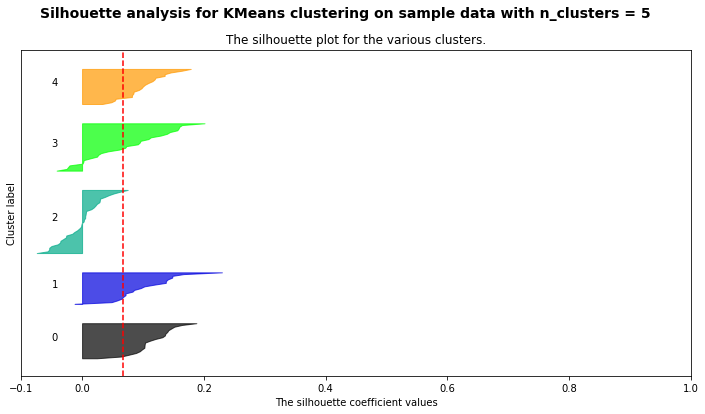

,Number of clusters,Average silhouette score,Size of cluster,Label assignements
0,2,0.166277,"{0: 60, 1: 66}","[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, ..."
1,3,0.119021,"{0: 61, 1: 43, 2: 22}","[0, 2, 0, 1, 2, 2, 2, 0, 0, 2, 2, 0, 0, 1, 0, ..."
2,4,0.083917,"{0: 28, 1: 36, 2: 25, 3: 37}","[2, 3, 1, 3, 0, 0, 0, 1, 2, 0, 0, 2, 1, 3, 1, ..."
3,5,0.067238,"{0: 21, 1: 19, 2: 37, 3: 28, 4: 21}","[0, 4, 4, 4, 1, 1, 1, 2, 0, 1, 1, 0, 0, 3, 2, ..."


In [12]:
# Convert DataFrame to matrix
afterCorrectedMat = afterCorrectedForms.as_matrix()
# Standardise the data
afterCorrectedMat = preprocessing.scale(afterCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
afterCorrectedResults = tryKmeans(afterCorrectedMat)
# Format results as a DataFrame
afterCorrectedResults = pd.DataFrame(data=afterCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
afterCorrectedResults

Will split columns into 6 groups


FloatProgress(value=0.0, max=6.0)

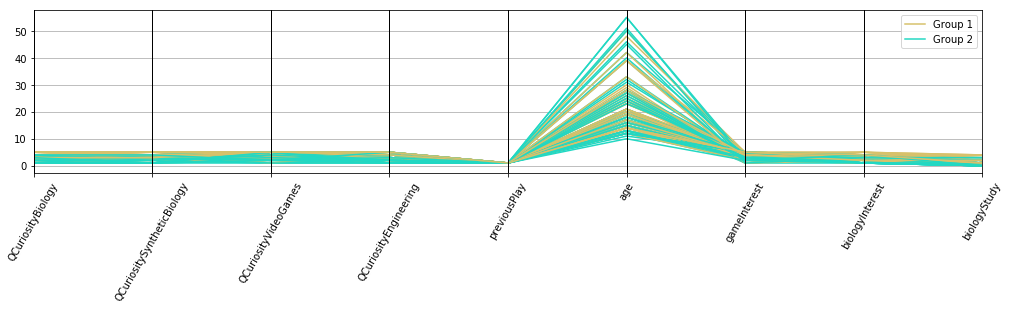

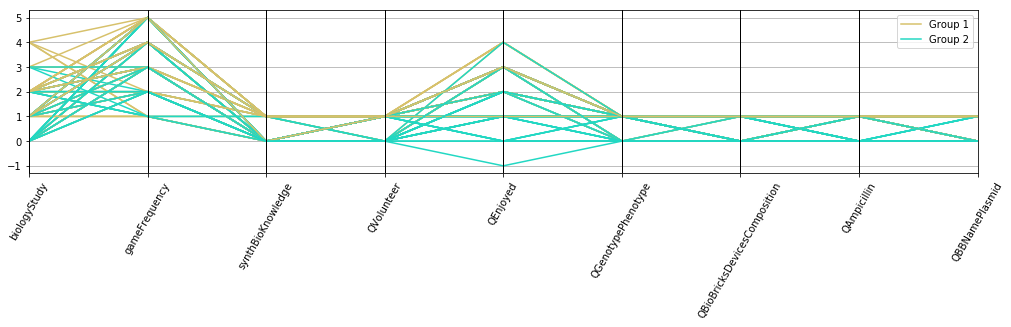

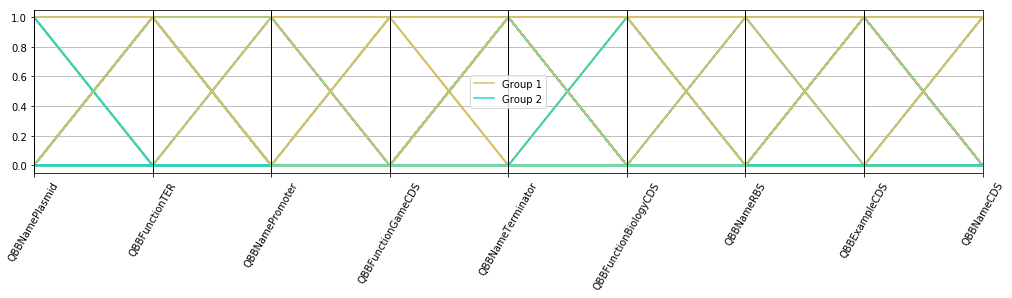

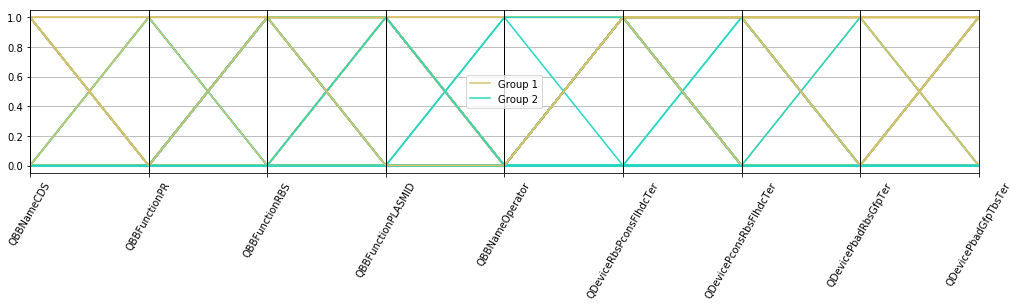

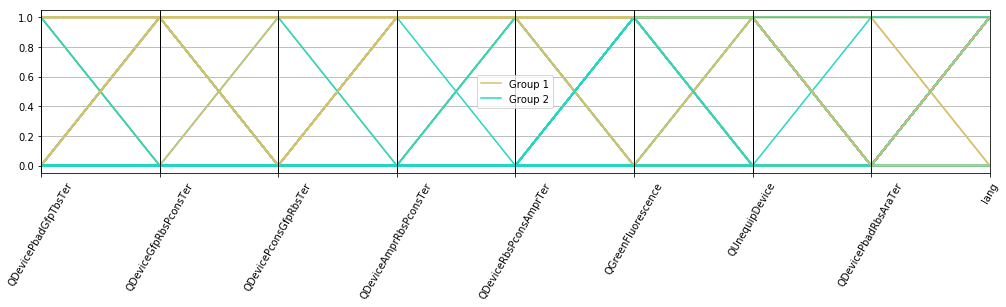

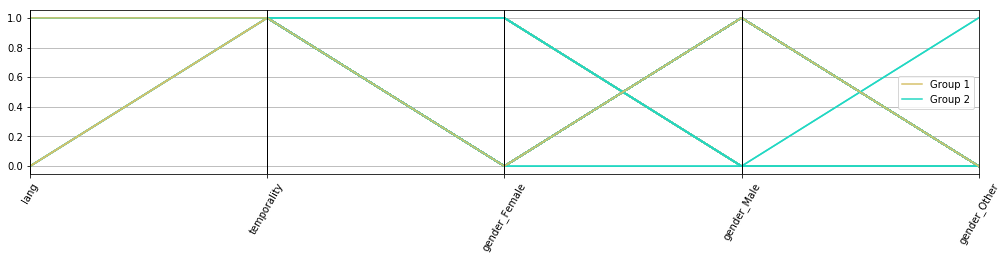

In [13]:
# Display parallel coordinates plot
assignements = detailsKmeans(afterCorrectedForms, afterCorrectedResults, 2, displayParallelCoord=True, clusterLabels=["Group 1", "Group 2"])

In [14]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeCorrectedForms, beforeCorrectedResults, 2, "allScience")
correctAnswersByCluster

,Cluster 0,Cluster 1
QGenotypePhenotype,0.072727,0.309859
QBioBricksDevicesComposition,0.018182,0.112676
QAmpicillin,0.127273,0.239437
QBBNamePlasmid,0.000000,0.014085
QBBFunctionTER,0.000000,0.028169
QBBNamePromoter,0.000000,0.056338
QBBFunctionGameCDS,0.000000,0.014085
QBBNameTerminator,0.036364,0.112676
QBBFunctionBiologyCDS,0.000000,0.042254
QBBNameRBS,0.000000,0.000000


In [15]:
stats.ttest_ind(correctAnswersByCluster["Cluster 0"], correctAnswersByCluster["Cluster 1"])

Ttest_indResult(statistic=-2.5260289355374366, pvalue=0.01462042756193679)

In [16]:
# Compute frequency of different levels of biology study for each group and each question
biologyStudyPerCluster = freqByCluster(beforeCorrectedForms, beforeCorrectedResults, 2, "biologyStudy")
biologyStudyPerCluster

Ttest_indResult(statistic=-1.5048276435585974, pvalue=0.13491134604003624)


,Cluster 0,Cluster 1
0,0.327273,0.197183
1,0.345455,0.295775
2,0.236364,0.450704
3,0.054545,0.028169
4,0.036364,0.028169


In [17]:
# Compute frequency of different levels of synthBioKnowledge for each group and each question
synthBioKnowledgePerCluster = freqByCluster(beforeCorrectedForms, beforeCorrectedResults, 2, "synthBioKnowledge")
synthBioKnowledgePerCluster

Ttest_indResult(statistic=-1.7478016179265945, pvalue=0.08297368594825064)


,Cluster 0,Cluster 1
0,0.727273,0.577465
1,0.272727,0.422535


In [18]:
# Compute score and compare clusters
afterCorrectedForms["sum"] = afterCorrectedForms.loc[:,"QGenotypePhenotype":"QDevicePbadRbsAraTer"].sum(axis=1)
scorePerCluster = freqByCluster(afterCorrectedForms, afterCorrectedResults, 2, "sum")
scorePerCluster

Ttest_indResult(statistic=20.042249754463256, pvalue=1.0435812200632852e-40)


,Cluster 0,Cluster 1
0.0,0.000000,0.075758
1.0,0.000000,0.121212
2.0,0.000000,0.121212
3.0,0.000000,0.075758
4.0,0.000000,0.136364
5.0,0.000000,0.121212
6.0,0.000000,0.136364
7.0,0.000000,0.060606
8.0,0.000000,0.060606
9.0,0.050000,0.030303


Conclusion: Two clusters, one with slightly higher level of biology Study and synthetic biology previous knowledge, and much higher scores. See above for details of questions. (29/05/18)

# Can the data be clustered according to the answers given to the questionnaire?

## If scientific questions are coded by answers

### If only before and after questionnaires are used

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


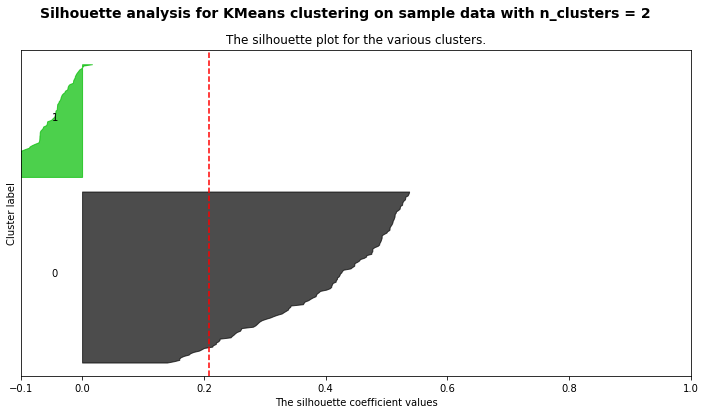

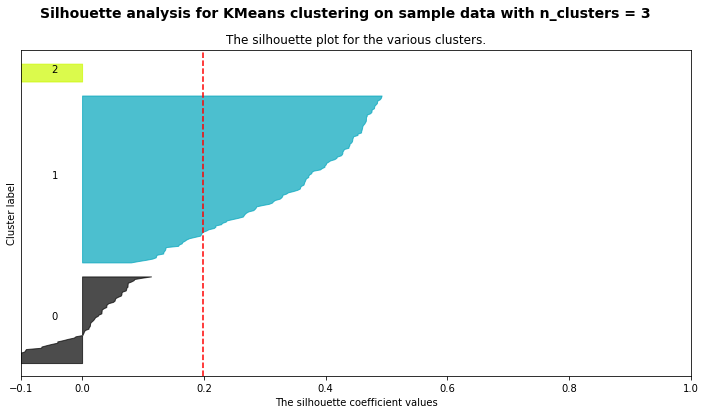

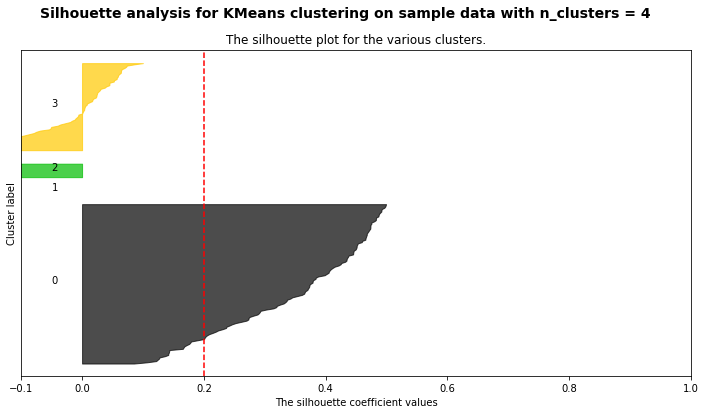

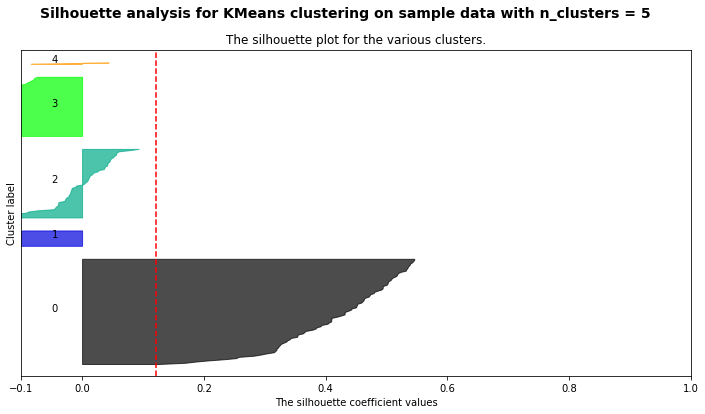

,Number of clusters,Average silhouette score,Size of cluster,Label assignements
0,2,0.208847,"{0: 130, 1: 86}","[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, ..."
1,3,0.198945,"{0: 69, 1: 132, 2: 15}","[1, 0, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, ..."
2,4,0.200502,"{0: 131, 1: 1, 2: 12, 3: 72}","[0, 3, 0, 2, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 3, ..."
3,5,0.121786,"{0: 90, 1: 14, 2: 59, 3: 51, 4: 2}","[0, 2, 3, 1, 0, 3, 3, 3, 3, 0, 3, 3, 0, 2, 2, ..."


In [19]:
# Convert DataFrame to matrix
defMat = defForms.drop("temporality", axis=1).as_matrix()
# Standardise data
defMat = preprocessing.scale(defMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
defResults = tryKmeans(defMat)
# Format results as a DataFrame
defResults = pd.DataFrame(data=defResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
defResults

Conclusion: No interesting clustering (29/05/18)

### If all questionnaires are used

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


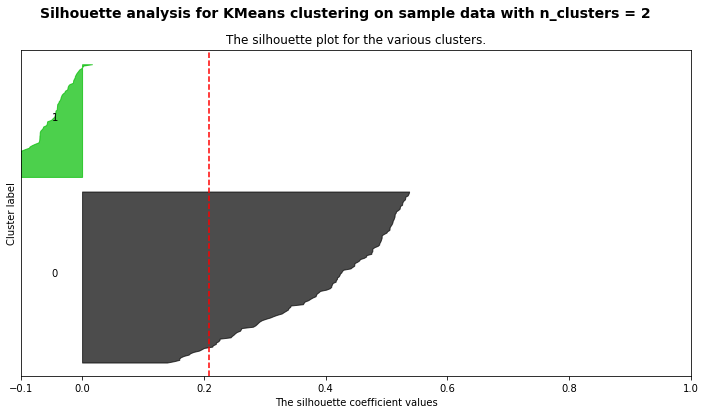

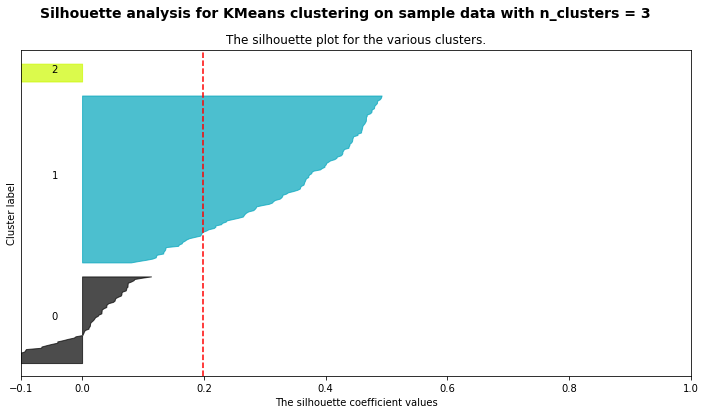

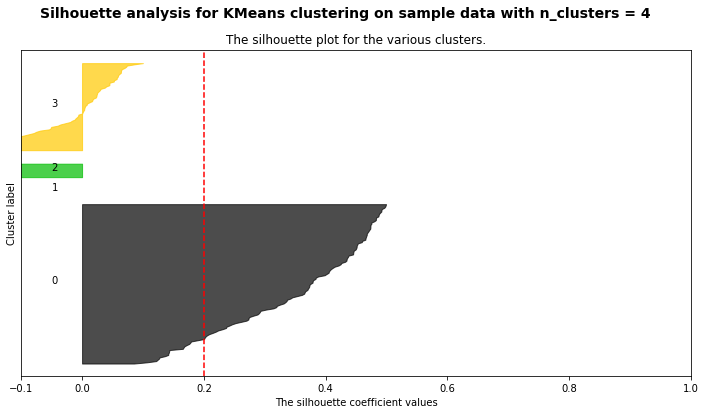

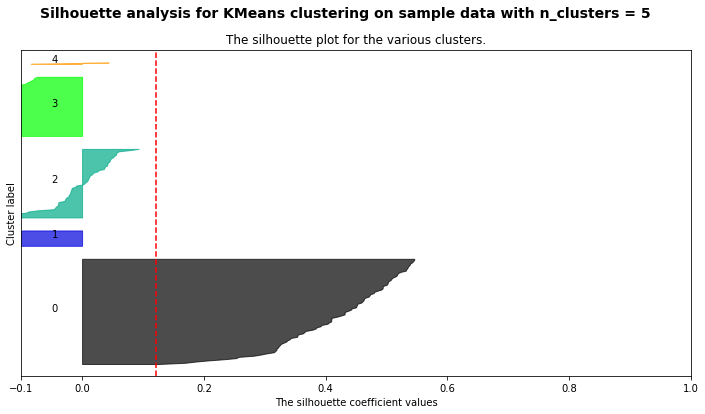

,Number of clusters,Average silhouette score,Size of cluster,Label assignements
0,2,0.208847,"{0: 130, 1: 86}","[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, ..."
1,3,0.198945,"{0: 69, 1: 132, 2: 15}","[1, 0, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, ..."
2,4,0.200502,"{0: 131, 1: 1, 2: 12, 3: 72}","[0, 3, 0, 2, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 3, ..."
3,5,0.121786,"{0: 90, 1: 14, 2: 59, 3: 51, 4: 2}","[0, 2, 3, 1, 0, 3, 3, 3, 3, 0, 3, 3, 0, 2, 2, ..."


In [20]:
# Convert DataFrame to matrix
allMat = allForms.drop("temporality", axis=1).as_matrix()
# Standardise data
allMat = preprocessing.scale(allMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
allResults = tryKmeans(allMat)
# Format results as a DataFrame
allResults = pd.DataFrame(data=allResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
allResults

Conclusion: No interesting clustering (16/01/2018)

In [21]:
assignements = detailsKmeans(allForms, allResults, 2)
assignements = pd.concat([assignements, allForms["temporality"]], axis=1, join='inner')
defConfusionMat = confusion_matrix(list(assignements["temporality"]), list(assignements["Index of cluster"]))
defConfusionMat = pd.DataFrame(data = defConfusionMat, columns=["Predicted before", "Predicted after"], index = ["Actual after", "Actual before"])
defConfusionMat

,Predicted before,Predicted after
Actual after,88,2
Actual before,42,84


## If scientific questions are coded by correctedness

### If only before and after questionnaires are used

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


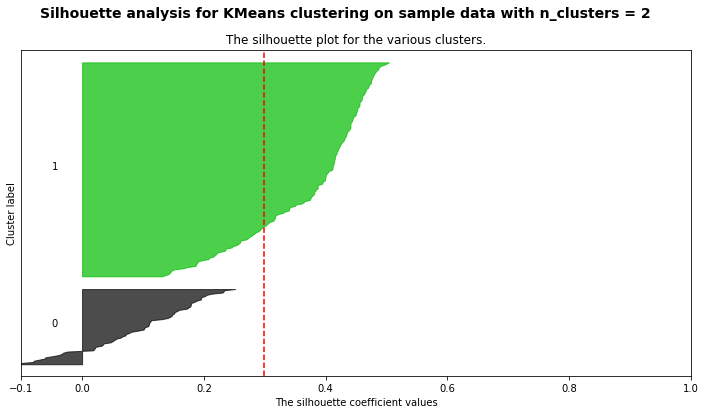

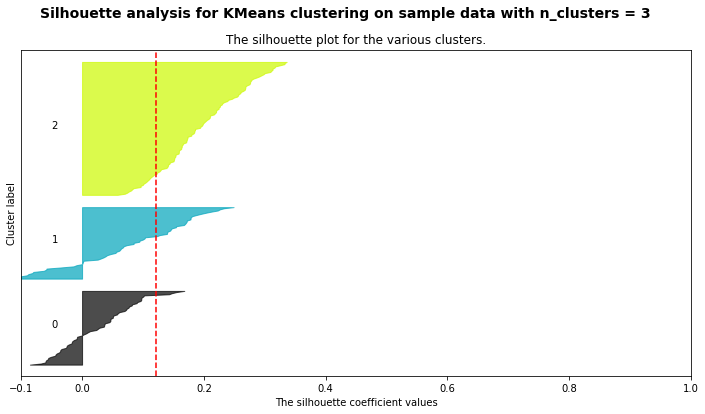

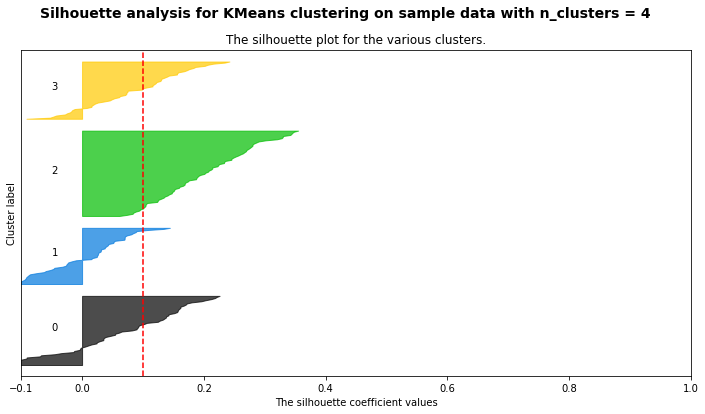

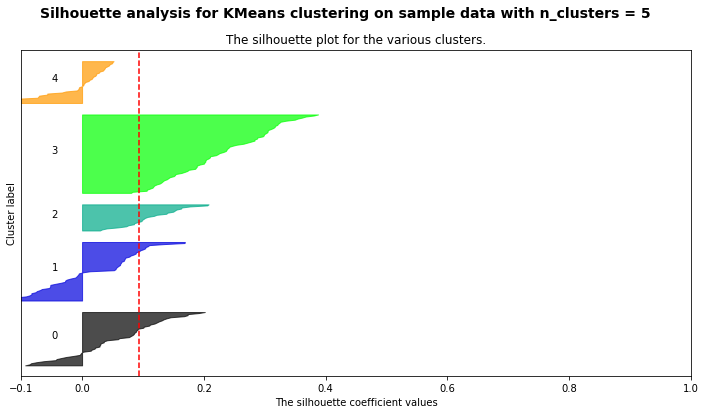

,Number of clusters,Average silhouette score,Size of cluster,Label assignements
0,2,0.299472,"{0: 66, 1: 186}","[1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, ..."
1,3,0.121125,"{0: 67, 1: 65, 2: 120}","[2, 1, 2, 2, 2, 2, 1, 2, 0, 1, 0, 2, 0, 0, 0, ..."
2,4,0.100633,"{0: 65, 1: 53, 2: 80, 3: 54}","[2, 0, 2, 3, 2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 1, ..."
3,5,0.093980,"{0: 52, 1: 57, 2: 26, 3: 76, 4: 41}","[3, 2, 3, 3, 3, 3, 4, 3, 1, 4, 1, 1, 1, 1, 1, ..."


In [22]:
# Convert DataFrame to matrix
defCorrectedMat = defCorrectedForms.drop("temporality", axis=1).as_matrix()
# Standardise data
defCorrectedMat = preprocessing.scale(defCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
defCorrectedResults = tryKmeans(defCorrectedMat)
# Format results as a DataFrame
defCorrectedResults = pd.DataFrame(data=defCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
defCorrectedResults

Conclusion: No interesting clustering (29/05/18)

### If all questionnaires are used

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


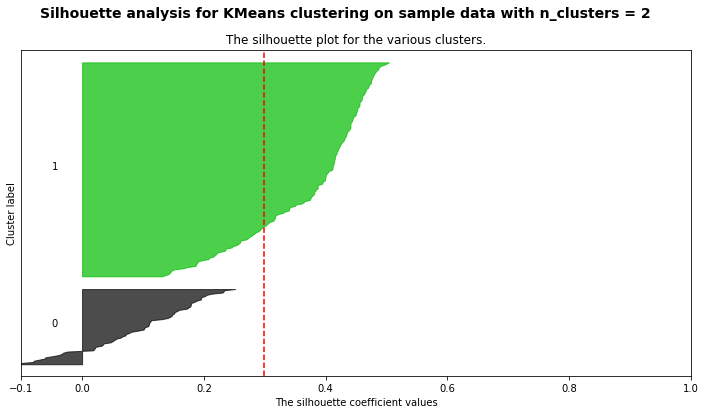

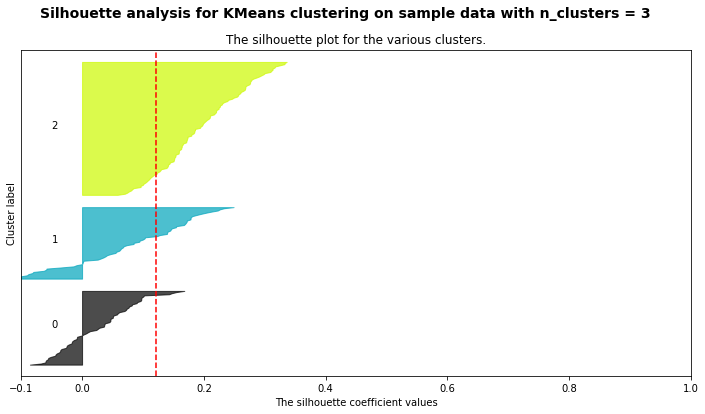

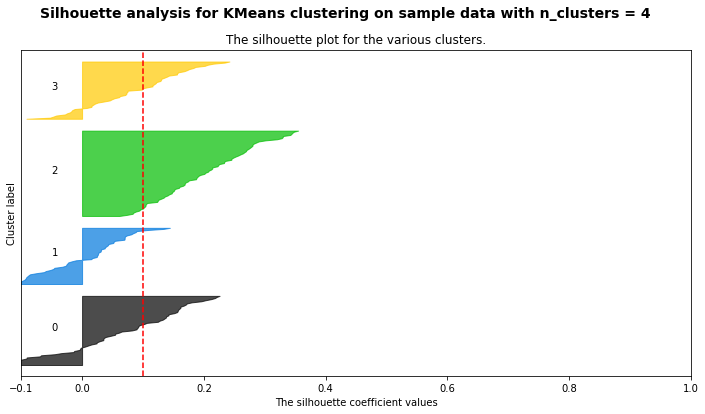

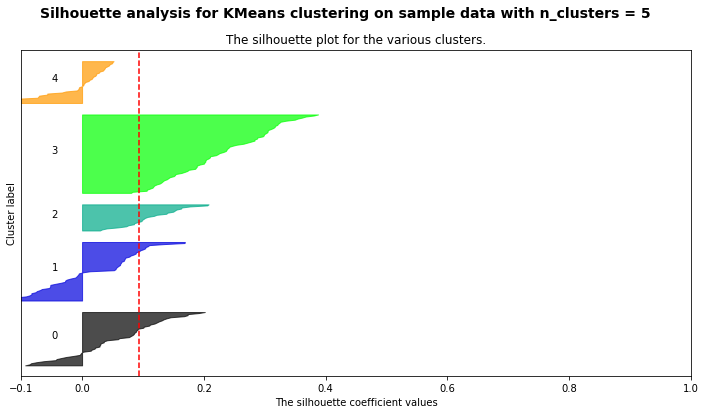

,Number of clusters,Average silhouette score,Size of cluster,Label assignements
0,2,0.299472,"{0: 66, 1: 186}","[1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, ..."
1,3,0.121125,"{0: 67, 1: 65, 2: 120}","[2, 1, 2, 2, 2, 2, 1, 2, 0, 1, 0, 2, 0, 0, 0, ..."
2,4,0.100633,"{0: 65, 1: 53, 2: 80, 3: 54}","[2, 0, 2, 3, 2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 1, ..."
3,5,0.093980,"{0: 52, 1: 57, 2: 26, 3: 76, 4: 41}","[3, 2, 3, 3, 3, 3, 4, 3, 1, 4, 1, 1, 1, 1, 1, ..."


In [23]:
# Convert DataFrame to matrix
allCorrectedMat = allCorrectedForms.drop("temporality", axis=1).as_matrix()
# Standardise data
allCorrectedMat = preprocessing.scale(allCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
allCorrectedResults = tryKmeans(allCorrectedMat)
# Format results as a DataFrame
allCorrectedResults = pd.DataFrame(data=allCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
allCorrectedResults

Conclusion: No interesting clustering (29/05/18)

# Can the data be clustered according to the answers given to both the before and the after questionnaire?

# TODO! Rethink meaning of this section with new experiment

## If scientific questions are coded by answers

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


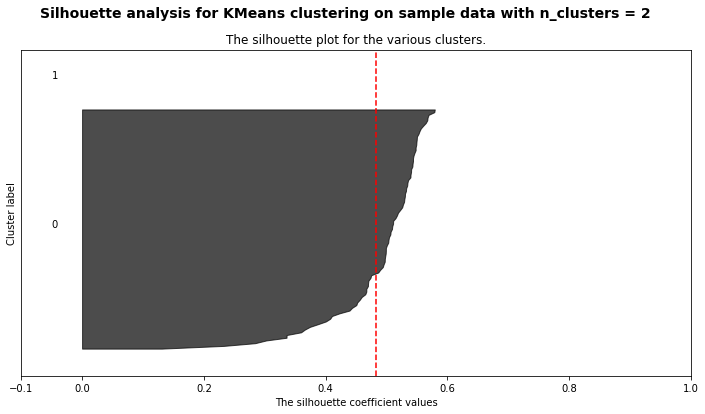

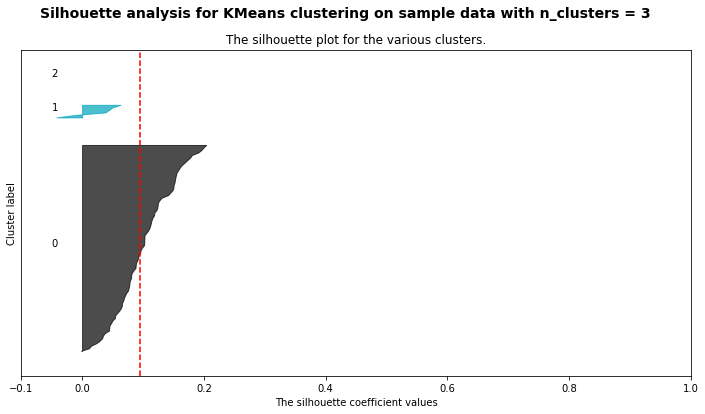

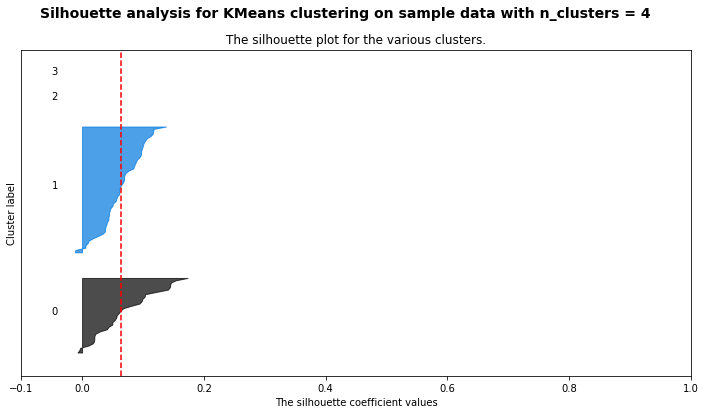

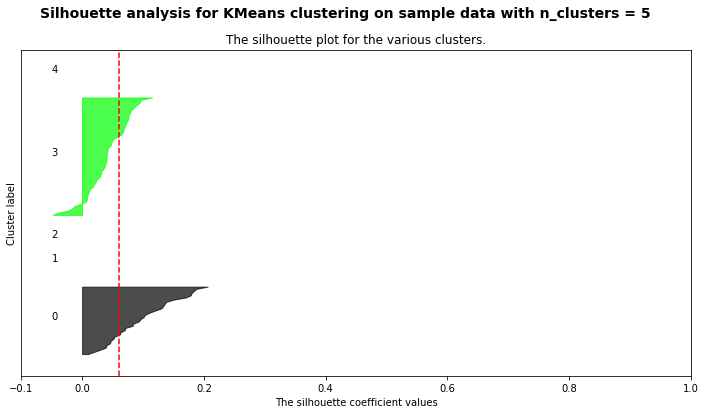

,Number of clusters,Average silhouette score,Size of cluster,Label assignements
0,2,0.483472,"{0: 89, 1: 1}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,3,0.095039,"{0: 83, 1: 6, 2: 1}","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,4,0.063908,"{0: 33, 1: 55, 2: 1, 3: 1}","[1, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, ..."
3,5,0.060490,"{0: 32, 1: 1, 2: 1, 3: 55, 4: 1}","[3, 2, 3, 0, 3, 3, 3, 0, 0, 3, 3, 0, 3, 3, 3, ..."


In [24]:
# Convert DataFrame to matrix
beforeAndAfterMat = beforeAndAfterForms.as_matrix()
# Standardise the data
beforeAndAfterMat = preprocessing.scale(beforeAndAfterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeAndAfterResults = tryKmeans(beforeAndAfterMat)
# Format results as a DataFrame
beforeAndAfterResults = pd.DataFrame(data=beforeAndAfterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeAndAfterResults

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


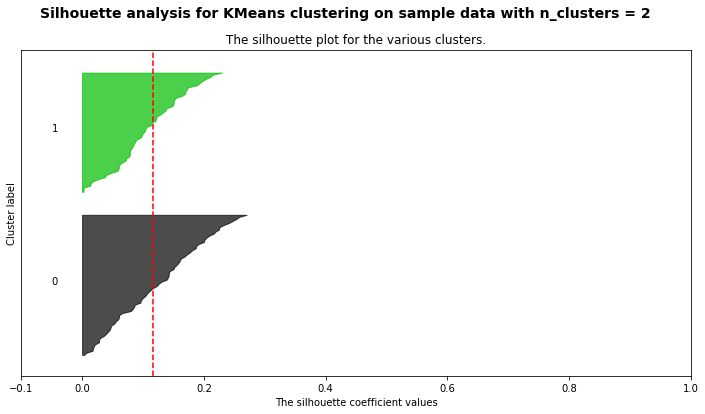

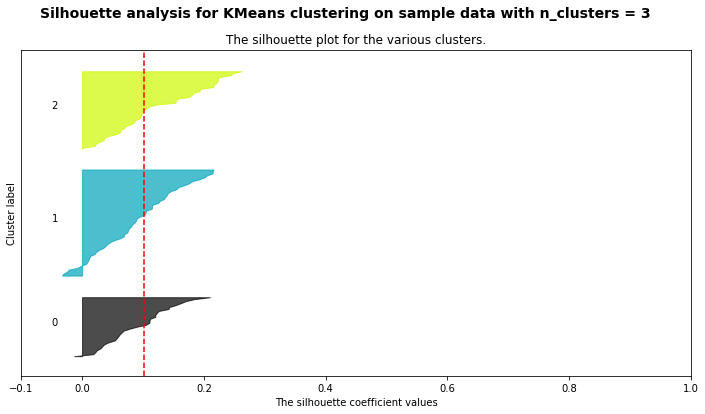

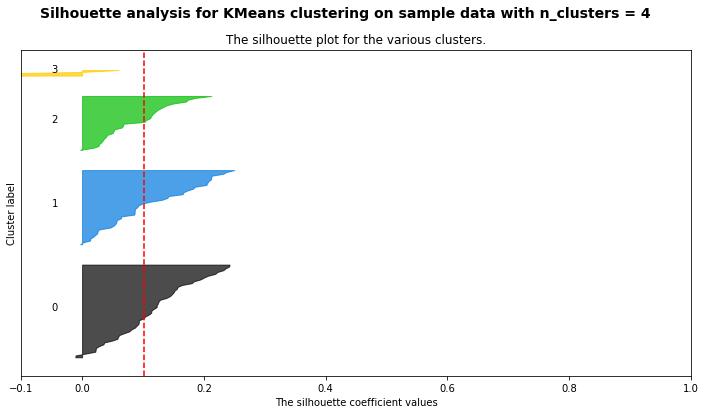

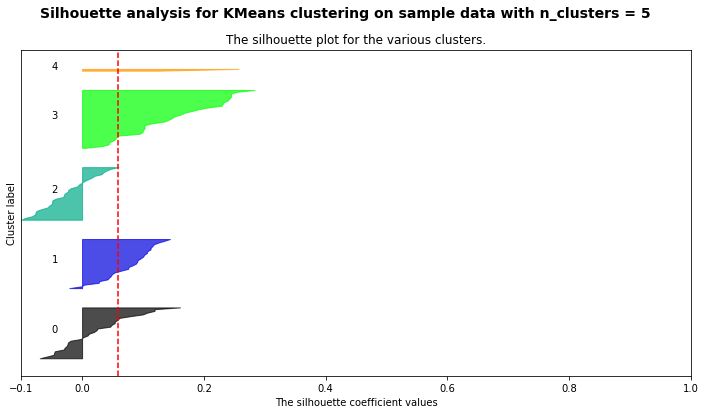

,Number of clusters,Average silhouette score,Size of cluster,Label assignements
0,2,0.116024,"{0: 68, 1: 58}","[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, ..."
1,3,0.100979,"{0: 31, 1: 55, 2: 40}","[1, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1, 2, ..."
2,4,0.101964,"{0: 51, 1: 41, 2: 30, 3: 4}","[0, 2, 1, 0, 2, 2, 2, 2, 0, 2, 0, 0, 1, 0, 1, ..."
3,5,0.059488,"{0: 30, 1: 29, 2: 31, 3: 34, 4: 2}","[2, 3, 3, 1, 0, 0, 1, 0, 2, 0, 1, 1, 3, 1, 3, ..."


In [25]:
# Convert DataFrame to matrix
beforeAndAfterCorrectedMat = beforeAndAfterCorrectedForms.as_matrix()
# Standardise the data
beforeAndAfterCorrectedMat = preprocessing.scale(beforeAndAfterCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeAndAfterCorrectedResults = tryKmeans(beforeAndAfterCorrectedMat)
# Format results as a DataFrame
beforeAndAfterCorrectedResults = pd.DataFrame(data=beforeAndAfterCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeAndAfterCorrectedResults

Conclusion: The data could be clustered in two groups (29/05/18)

Will split columns into 12 groups


FloatProgress(value=0.0, max=12.0)

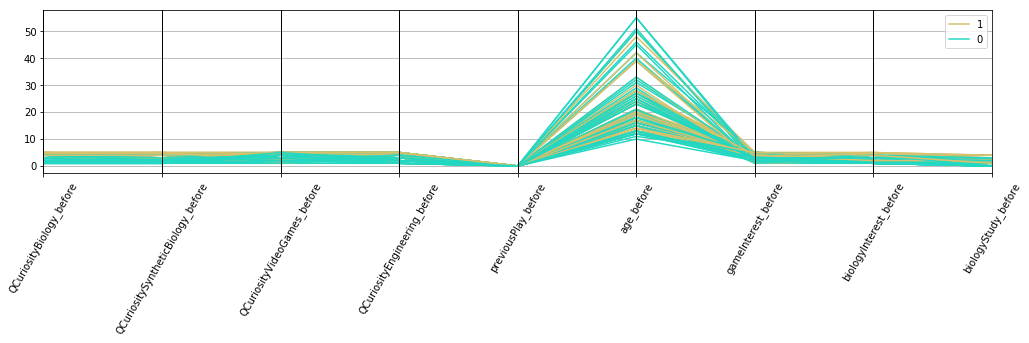

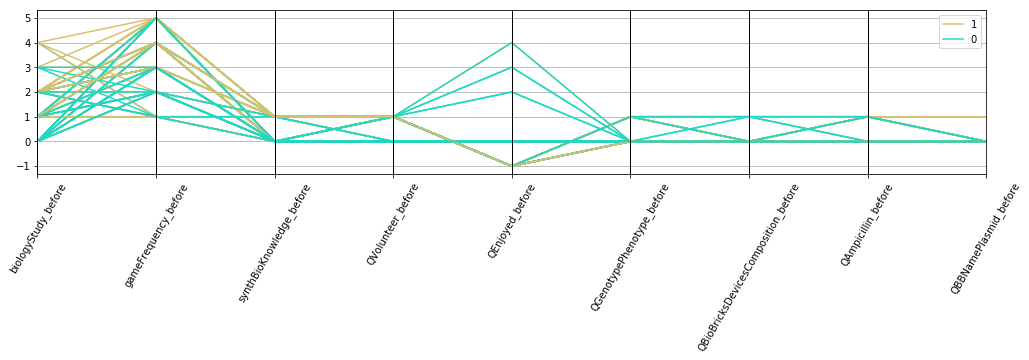

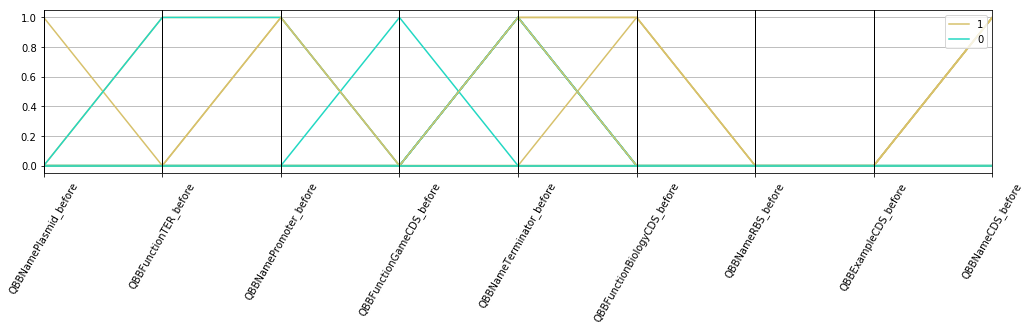

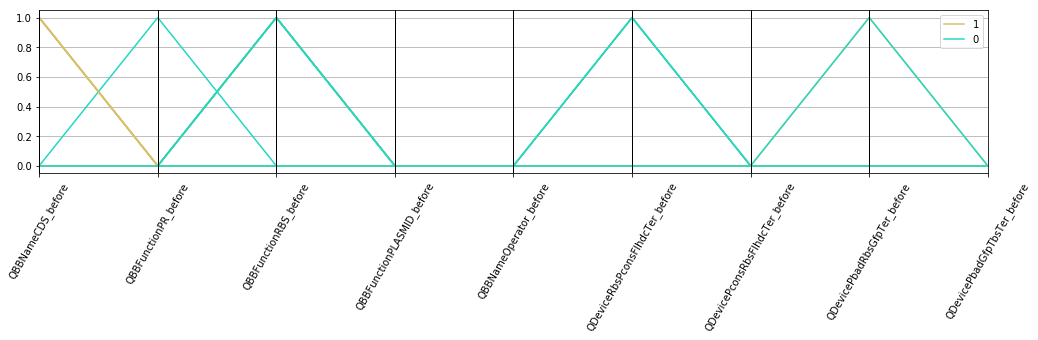

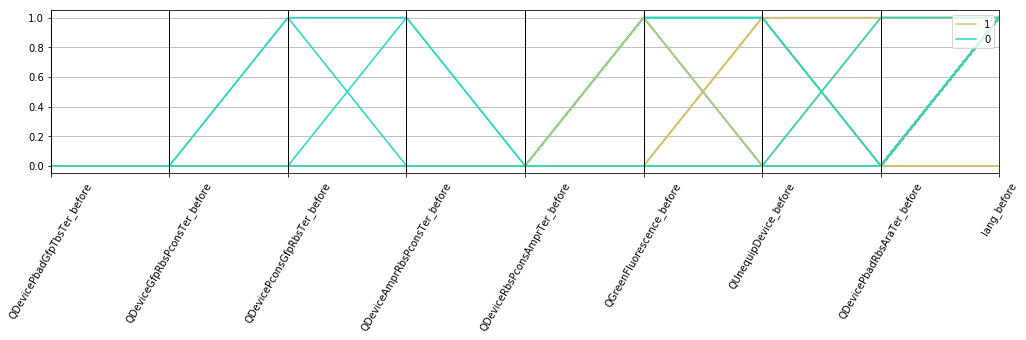

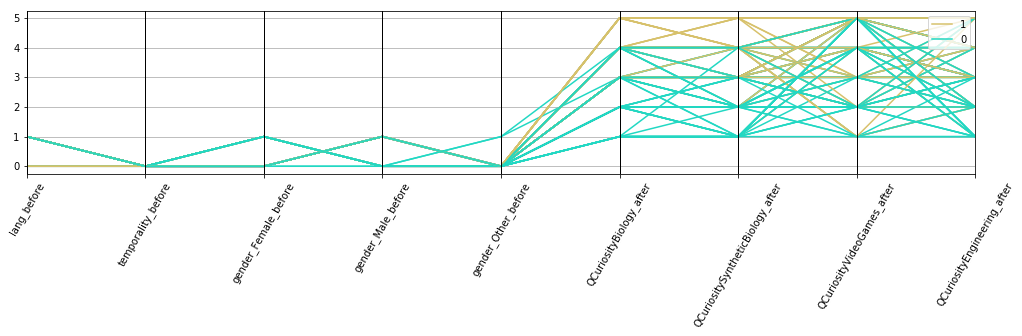

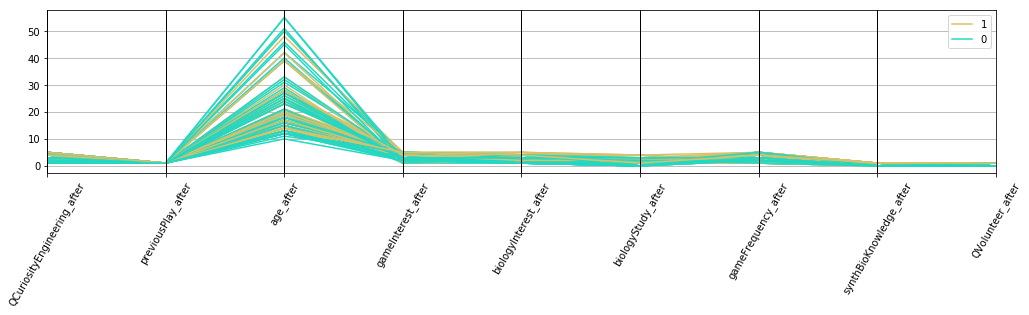

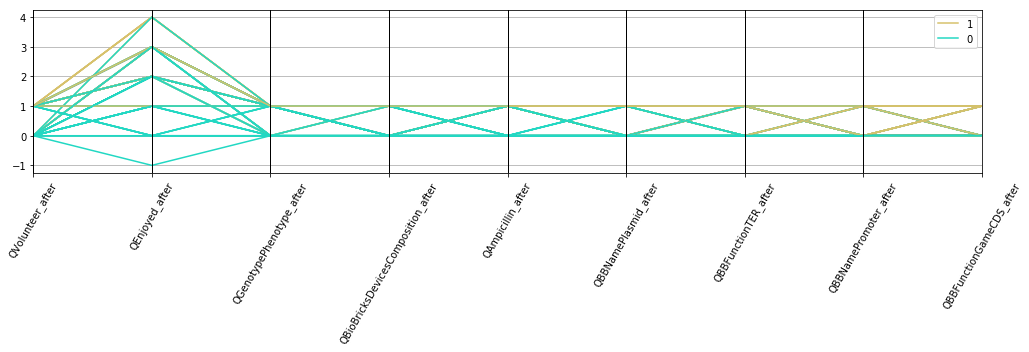

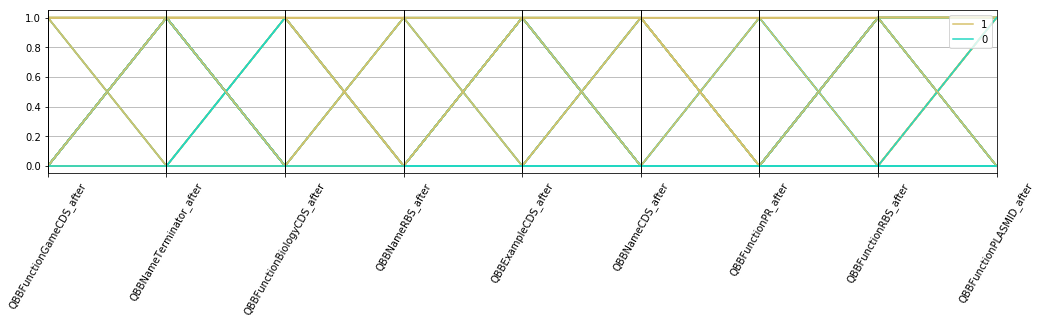

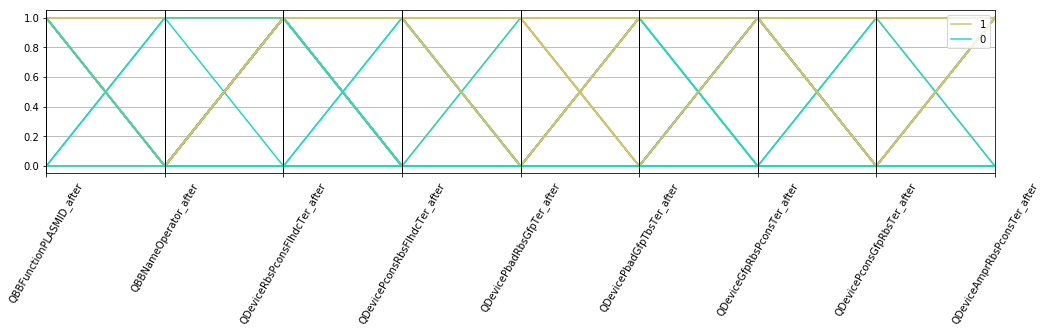

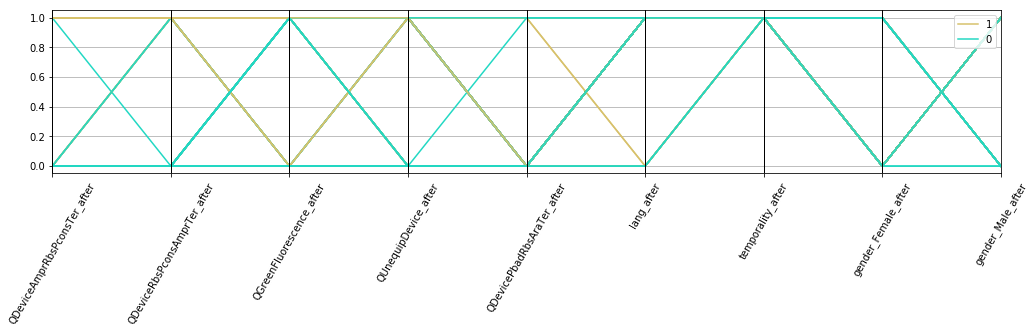

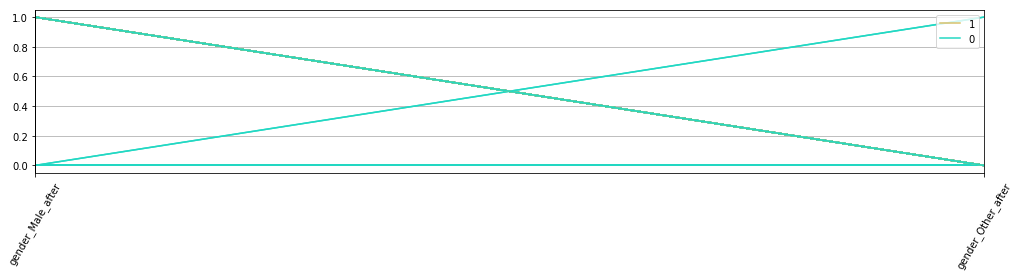

In [26]:
assignements = detailsKmeans(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, displayParallelCoord=True)

In [27]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "previousPlay_before")
correctAnswersByCluster

Ttest_indResult(statistic=nan, pvalue=nan)


C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\scipy\stats\_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\scipy\stats\_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in less
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\scipy\stats\_distn_infrastructure.py:1749: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,Cluster 0,Cluster 1
0,1.0,1.0


In [28]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "biologyInterest_before")
correctAnswersByCluster

Ttest_indResult(statistic=-4.385503027790872, pvalue=2.443150549162428e-05)


,Cluster 0,Cluster 1
1,0.264706,0.034483
2,0.205882,0.103448
3,0.367647,0.586207
4,0.161765,0.189655
5,0.000000,0.086207


In [29]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "biologyStudy_before")
correctAnswersByCluster

Ttest_indResult(statistic=-3.348633082362405, pvalue=0.0010759531564337311)


,Cluster 0,Cluster 1
0,0.367647,0.120690
1,0.323529,0.310345
2,0.250000,0.482759
3,0.044118,0.034483
4,0.014706,0.051724


In [30]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "biologyInterest_after")
correctAnswersByCluster

Ttest_indResult(statistic=-4.385503027790872, pvalue=2.443150549162428e-05)


,Cluster 0,Cluster 1
1,0.264706,0.034483
2,0.205882,0.103448
3,0.367647,0.586207
4,0.161765,0.189655
5,0.000000,0.086207


TODO Raphael: Look in details at scientific questions

# Can the data be clustered according to the RedMetrics values?

## All sessions

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


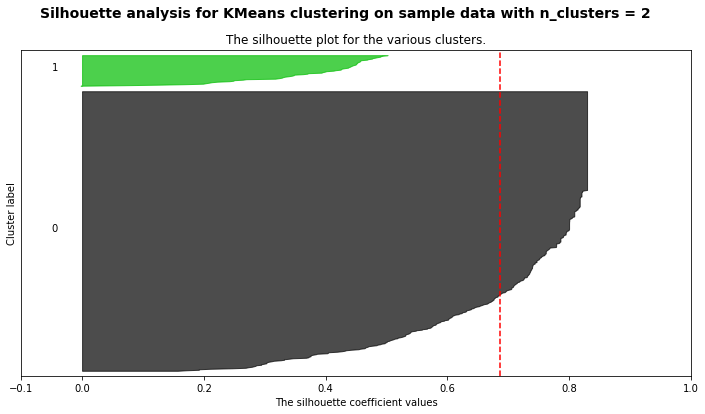

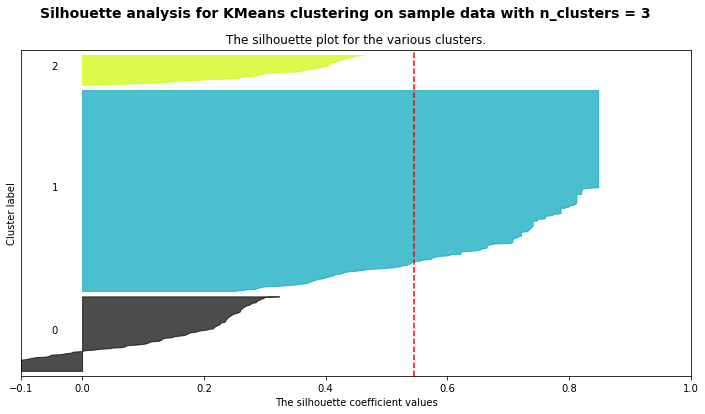

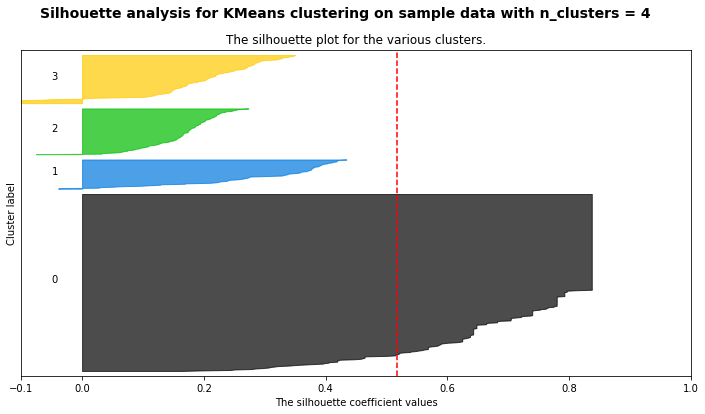

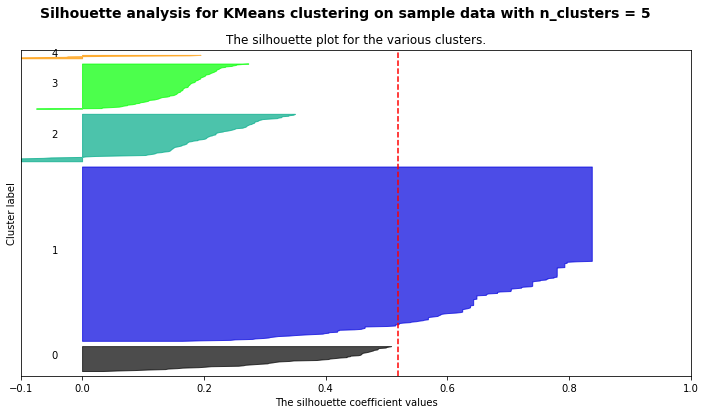

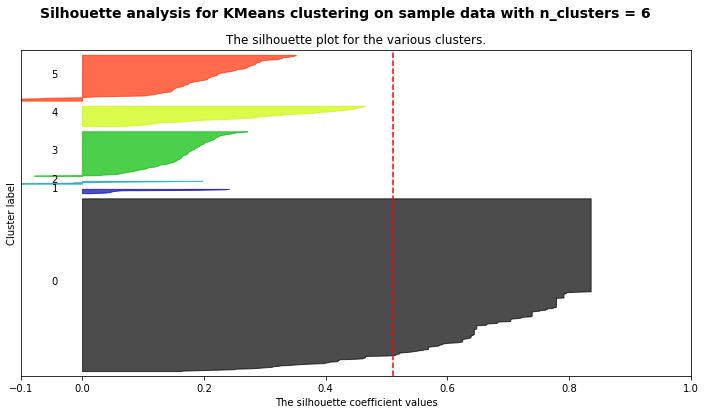

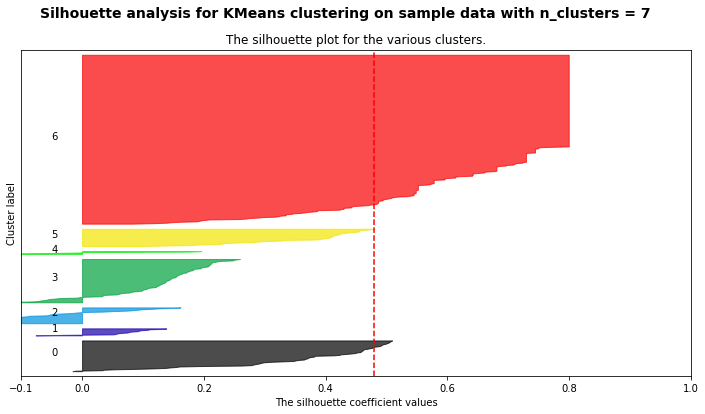

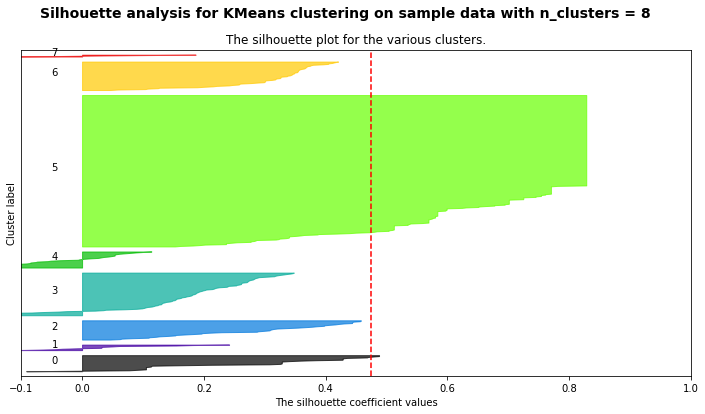

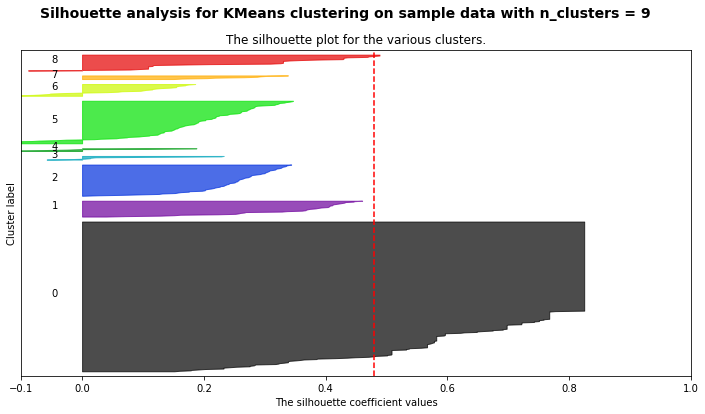

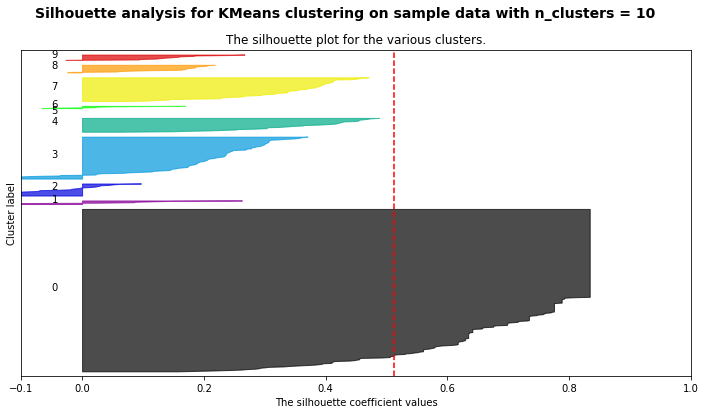

,Number of clusters,Average silhouette score,Size of cluster,Label assignements
0,2,0.685945,"{0: 559, 1: 62}","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,3,0.545622,"{0: 152, 1: 408, 2: 61}","[1, 1, 1, 1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, ..."
2,4,0.516860,"{0: 365, 1: 61, 2: 95, 3: 100}","[0, 0, 0, 3, 0, 3, 1, 0, 3, 3, 0, 0, 0, 0, 0, ..."
3,5,0.518742,"{0: 53, 1: 365, 2: 100, 3: 95, 4: 8}","[1, 1, 1, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 1, 1, ..."
4,6,0.511277,"{0: 367, 1: 10, 2: 7, 3: 95, 4: 44, 5: 98}","[0, 0, 0, 5, 0, 5, 4, 0, 5, 5, 0, 0, 0, 0, 0, ..."
5,7,0.479750,"{0: 67, 1: 16, 2: 35, 3: 94, 4: 7, 5: 38, 6: 364}","[6, 6, 6, 0, 6, 0, 5, 6, 0, 0, 6, 6, 6, 6, 6, ..."
6,8,0.475343,"{0: 36, 1: 13, 2: 43, 3: 94, 4: 36, 5: 331, 6:...","[5, 5, 5, 3, 5, 3, 2, 5, 3, 6, 0, 0, 5, 5, 5, ..."
7,9,0.479796,"{0: 332, 1: 36, 2: 70, 3: 9, 4: 7, 5: 95, 6: 2...","[0, 0, 0, 5, 0, 5, 1, 0, 5, 5, 8, 8, 0, 0, 0, ..."
8,10,0.512951,"{0: 365, 1: 9, 2: 28, 3: 95, 4: 32, 5: 1, 6: 6...","[0, 0, 0, 3, 0, 3, 4, 0, 3, 7, 0, 0, 0, 0, 0, ..."


In [31]:
# Convert DataFrame to matrix
allDataMat = allData.iloc[:,:-1].as_matrix()
# Standardise the data
allDataMat = preprocessing.scale(allDataMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
allDataResults = tryKmeans(allDataMat, rangeNbClusters=[2, 3, 4, 5, 6, 7, 8, 9, 10])
# Format results as a DataFrame
allDataResults = pd.DataFrame(data=allDataResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
allDataResults

Conclusion: Could be clustered in two groups (29/05/18)

Let's look at the parallel coordinates plot for 2 clusters

Will split columns into 5 groups


FloatProgress(value=0.0, max=5.0)

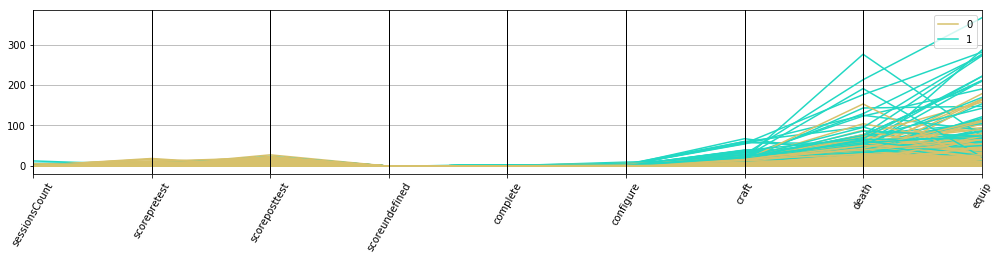

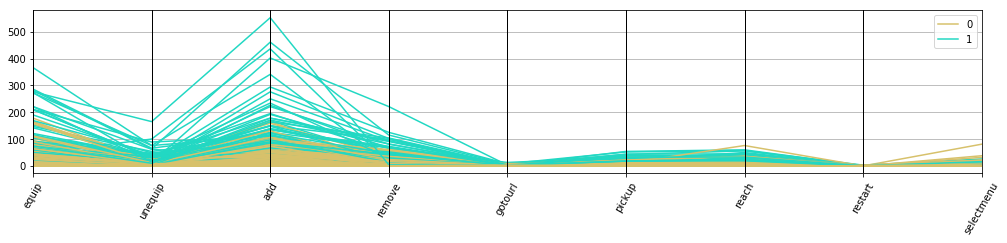

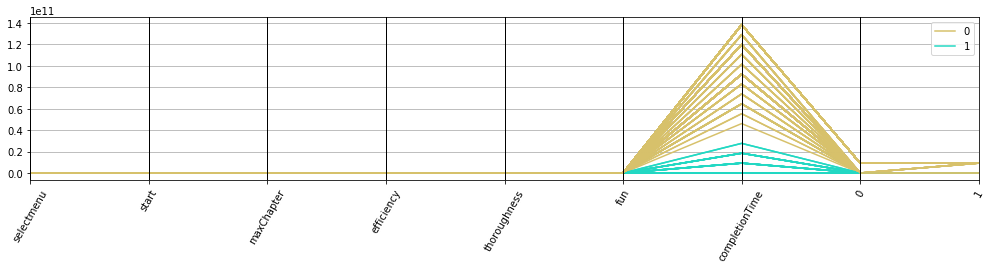

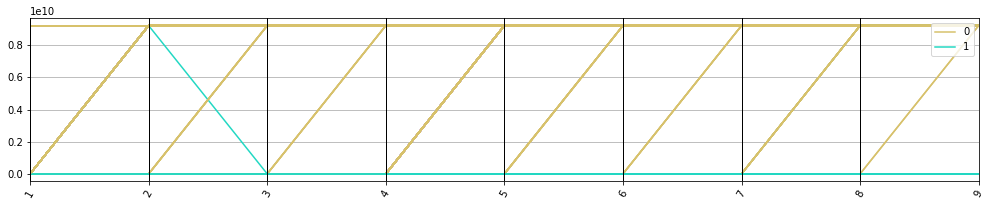

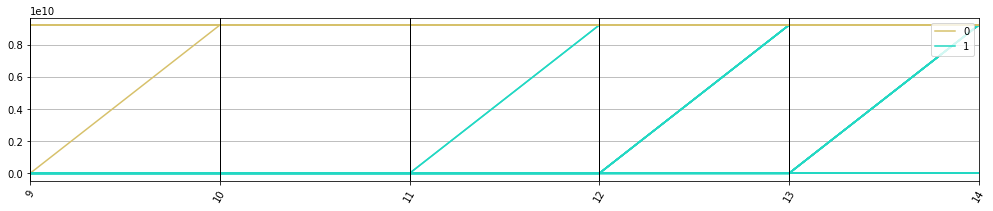

In [32]:
assignements = detailsKmeans(allData, allDataResults, 2, displayParallelCoord=True)

TODO Raphaeal : Check in details, Maybe check sub-divisions of clusters?

## Only sessions where the player has answered the questionnaire before and after playing

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


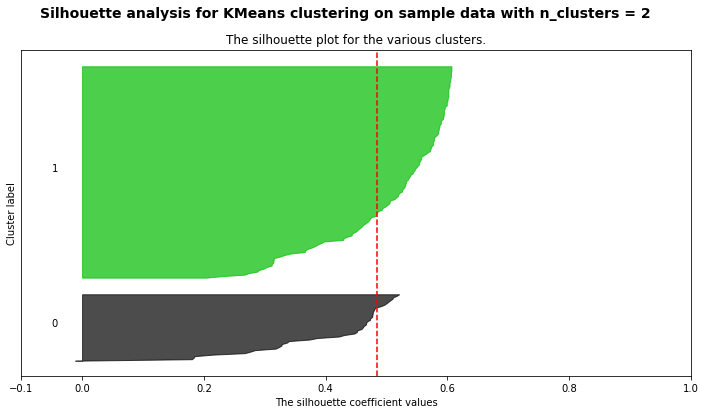

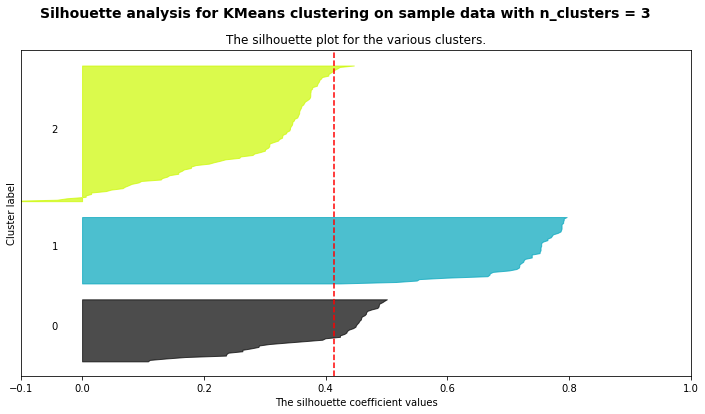

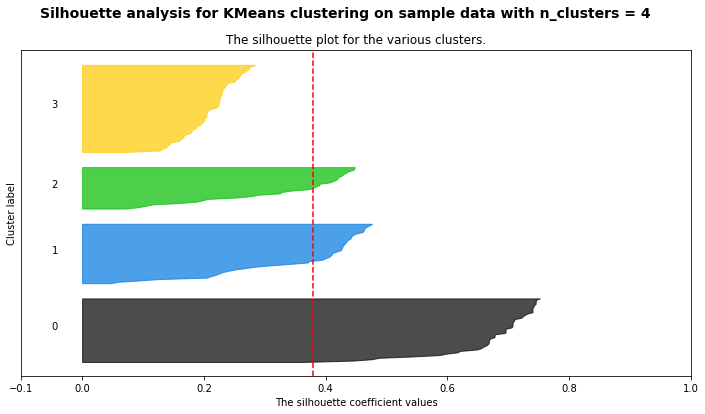

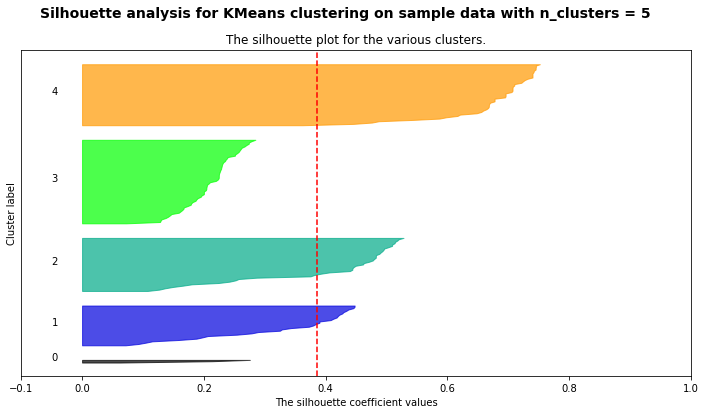

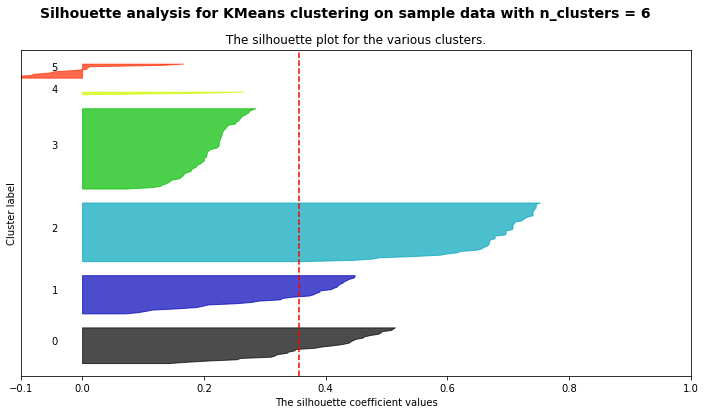

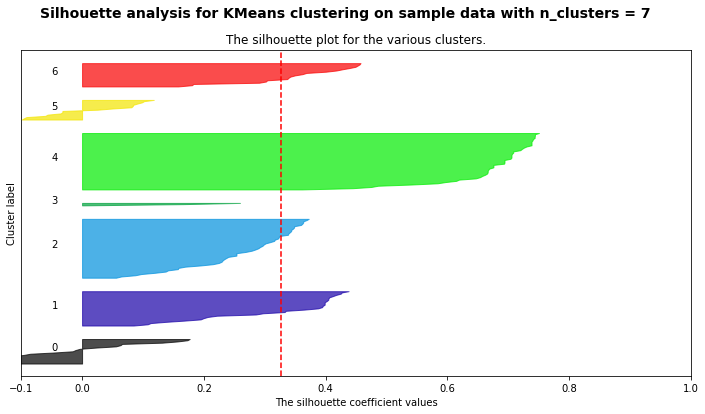

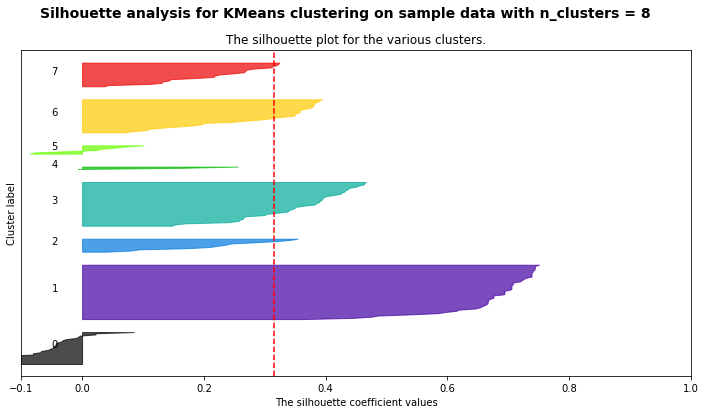

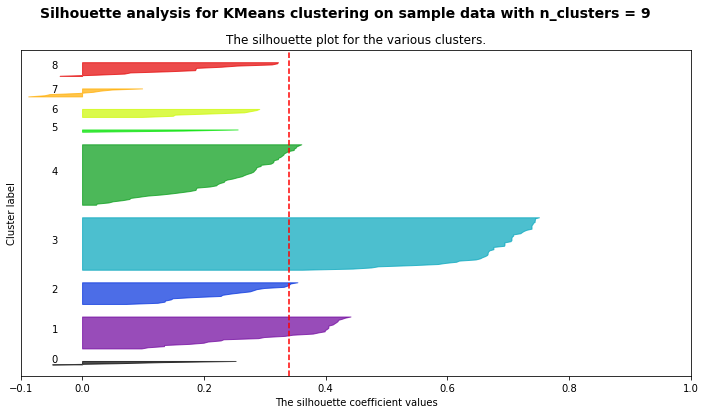

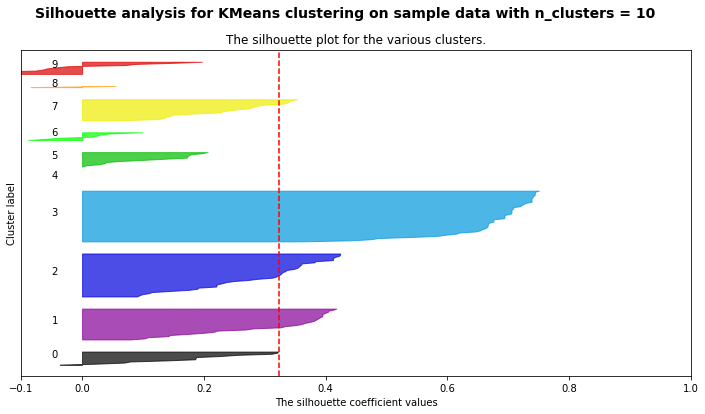

,Number of clusters,Average silhouette score,Size of cluster,Label assignements
0,2,0.484145,"{0: 45, 1: 141}","[1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, ..."
1,3,0.414140,"{0: 44, 1: 47, 2: 95}","[1, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 1, 2, 2, 0, ..."
2,4,0.379450,"{0: 47, 1: 44, 2: 31, 3: 64}","[0, 3, 1, 2, 1, 1, 3, 3, 1, 1, 3, 0, 2, 2, 1, ..."
3,5,0.385837,"{0: 3, 1: 31, 2: 41, 3: 64, 4: 47}","[4, 3, 2, 1, 0, 2, 3, 3, 2, 2, 3, 4, 1, 1, 2, ..."
4,6,0.355864,"{0: 29, 1: 31, 2: 47, 3: 64, 4: 3, 5: 12}","[2, 3, 0, 1, 4, 0, 3, 3, 0, 0, 3, 2, 1, 1, 0, ..."
5,7,0.326714,"{0: 21, 1: 29, 2: 49, 3: 3, 4: 47, 5: 17, 6: 20}","[4, 5, 6, 1, 3, 6, 2, 2, 0, 0, 2, 4, 1, 2, 6, ..."
6,8,0.315691,"{0: 28, 1: 47, 2: 12, 3: 38, 4: 3, 5: 8, 6: 29...","[1, 0, 7, 6, 4, 7, 3, 0, 2, 2, 3, 1, 6, 3, 7, ..."
7,9,0.340285,"{0: 4, 1: 29, 2: 20, 3: 47, 4: 54, 5: 3, 6: 8,...","[3, 0, 2, 1, 5, 2, 4, 4, 8, 8, 4, 3, 1, 4, 2, ..."
8,10,0.323335,"{0: 13, 1: 29, 2: 40, 3: 47, 4: 1, 5: 14, 6: 8...","[3, 9, 7, 1, 8, 7, 2, 2, 0, 0, 2, 3, 1, 2, 7, ..."


In [33]:
# Convert DataFrame to matrix
fullProcessDataMat = fullProcessData.as_matrix()
# Standardise the data
fullProcessDataMat = preprocessing.scale(fullProcessDataMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
fullProcessDataResults = tryKmeans(fullProcessDataMat, rangeNbClusters=[2, 3, 4, 5, 6, 7, 8, 9, 10])
# Format results as a DataFrame
fullProcessDataResults = pd.DataFrame(data=fullProcessDataResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
fullProcessDataResults

Conclusion: The data can be clustered in two groups or three groups (29/05/18)

Will split columns into 5 groups


FloatProgress(value=0.0, max=5.0)

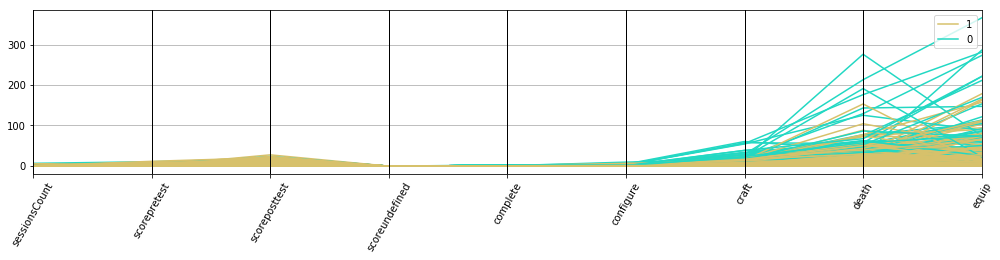

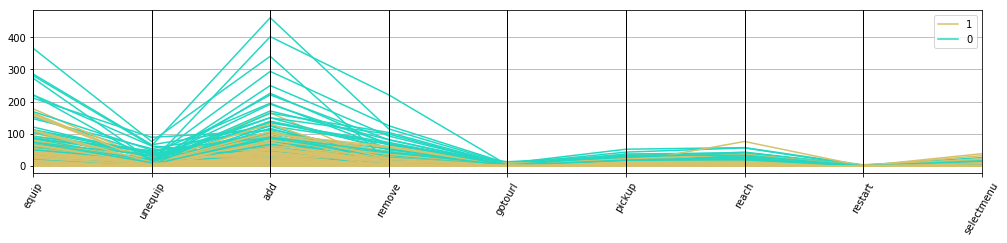

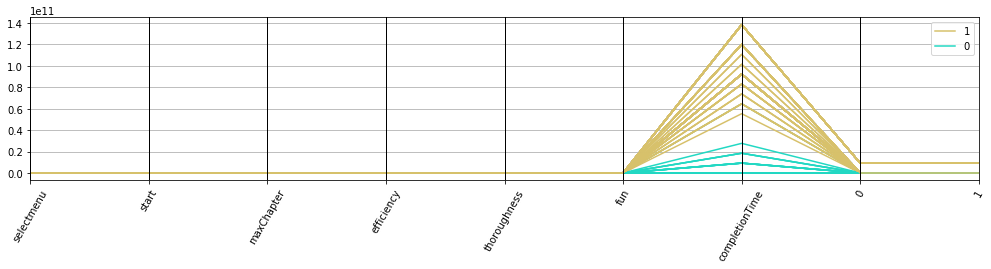

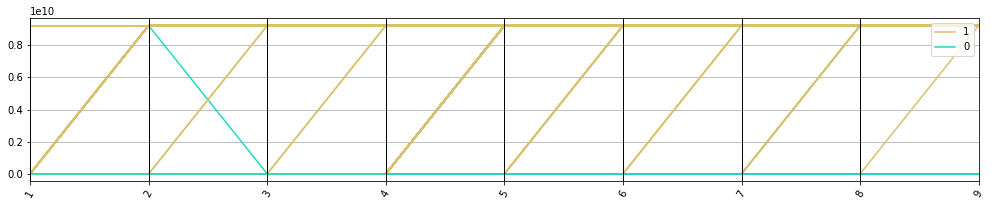

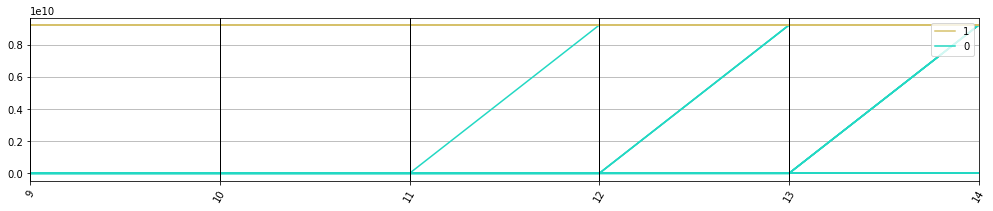

In [34]:
assignements = detailsKmeans(fullProcessData, fullProcessDataResults, 2, displayParallelCoord=True)

In [35]:
# Compute frequency of different levels of scores for each group
scores_before = freqByCluster(fullProcessData, fullProcessDataResults, 2, "scorepretest")
scores_after = freqByCluster(fullProcessData, fullProcessDataResults, 2, "scoreposttest")

Ttest_indResult(statistic=0.7713253426715303, pvalue=0.4415035129202268)
Ttest_indResult(statistic=7.641394879430806, pvalue=1.1446968218568233e-12)


In [36]:
# Compare groups for behaviors
freqByCluster(fullProcessData, fullProcessDataResults, 2, "configure")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "craft")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "equip")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "death")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "add")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "unequip")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "remove")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "pickup")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "reach")

Ttest_indResult(statistic=1.5034351839586695, pvalue=0.13444128008715628)
Ttest_indResult(statistic=13.787114264607284, pvalue=3.662221951607494e-30)
Ttest_indResult(statistic=7.163225309664772, pvalue=1.835128259516948e-11)
Ttest_indResult(statistic=8.538846650008246, pvalue=5.009774199878602e-15)
Ttest_indResult(statistic=11.924707111381224, pvalue=1.1725885975091411e-24)
Ttest_indResult(statistic=9.495087844823319, pvalue=1.1834342666218175e-17)
Ttest_indResult(statistic=11.81055990360085, pvalue=2.5391986896716763e-24)
Ttest_indResult(statistic=13.652317236313912, pvalue=9.179763087678239e-30)
Ttest_indResult(statistic=11.415482309445666, pvalue=3.653969756124376e-23)


,Cluster 0,Cluster 1
0.0,0.000000,0.340426
2.0,0.000000,0.134752
3.0,0.000000,0.007092
4.0,0.000000,0.042553
5.0,0.000000,0.070922
6.0,0.000000,0.021277
7.0,0.000000,0.056738
8.0,0.000000,0.021277
9.0,0.000000,0.049645
10.0,0.000000,0.014184


Conclusion: Clusters in two groups with different behaviours and scores! (29/05/18)
TODO RAPHAEL: Check clusters (2 groups and 3 clusters)

# Can the data be clustered according to the RedMetrics and the answers to the after questionnaire?

## If scientific questions are coded by answers

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


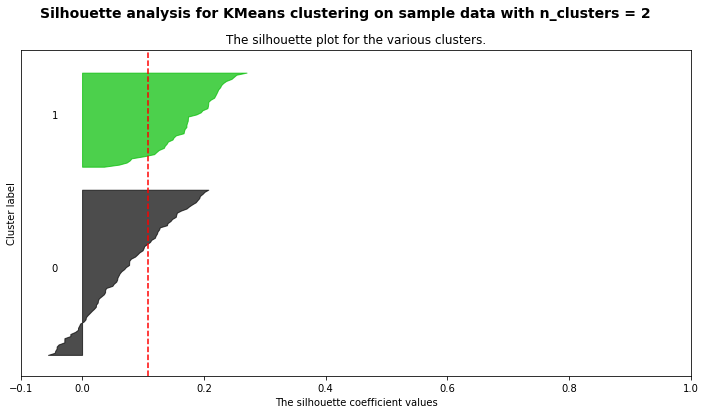

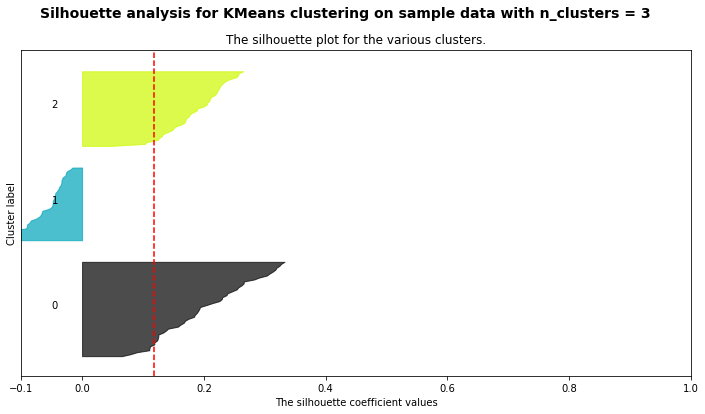

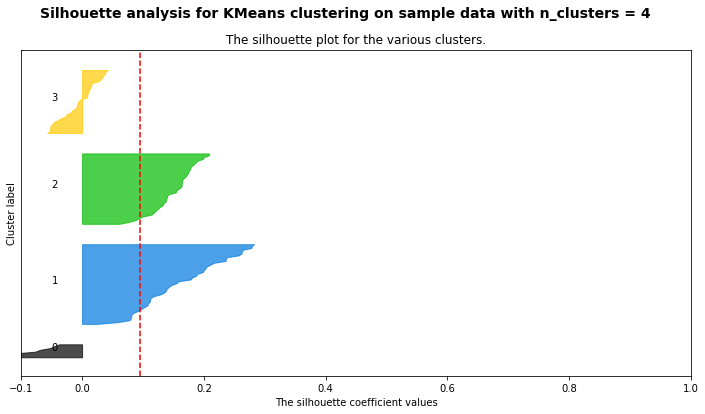

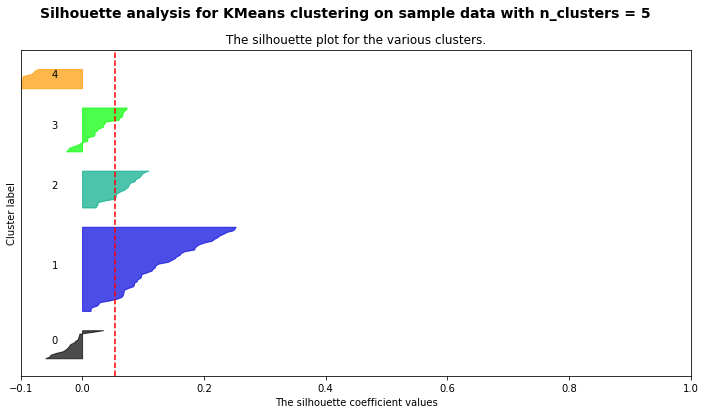

In [37]:
# Convert DataFrame to matrix
gameAndAfterMat = gameAndAfterData.as_matrix()
# Standardise the data
gameAndAfterMat = preprocessing.scale(gameAndAfterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
gameAndAfterResults = tryKmeans(gameAndAfterMat)
# Format results as a DataFrame
gameAndAfterResults = pd.DataFrame(data=gameAndAfterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])

Conclusion: Two-clustering (29/05/18)

## If scientific questions are coded by correctedness

C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mikael\Anaconda3\envs\conda-env-python3-py\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


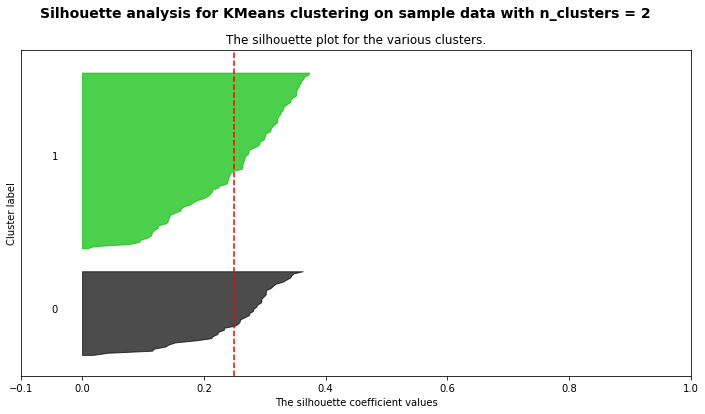

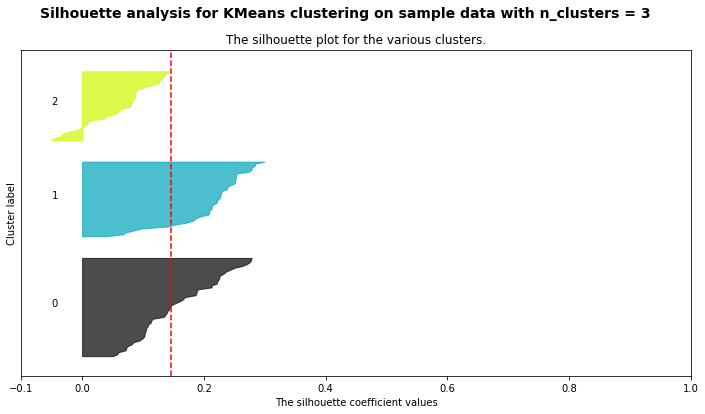

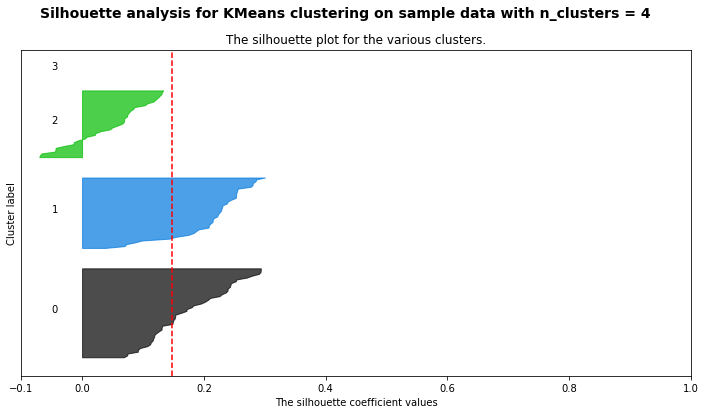

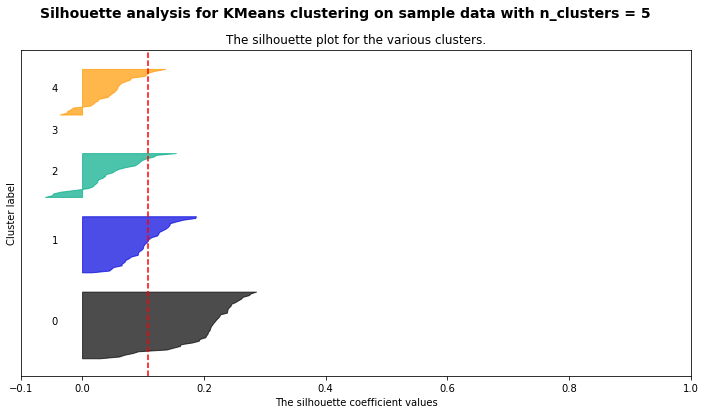

In [38]:
# Convert DataFrame to matrix
gameAndCorrectedAfterMat = gameAndCorrectedAfterData.as_matrix()
# Standardise the data
gameAndCorrectedAfterMat = preprocessing.scale(gameAndCorrectedAfterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
gameAndCorrectedAfterResults = tryKmeans(gameAndCorrectedAfterMat)
# Format results as a DataFrame
gameAndCorrectedAfterResults = pd.DataFrame(data=gameAndCorrectedAfterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])

Conclusion: No interesting clustering (19/12/2017)

In [39]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "allScience")
correctAnswersByCluster

,Cluster 0,Cluster 1
QGenotypePhenotype,0.975610,0.694118
QBioBricksDevicesComposition,0.780488,0.411765
QAmpicillin,0.853659,0.470588
QBBNamePlasmid,0.439024,0.235294
QBBFunctionTER,0.658537,0.294118
QBBNamePromoter,0.243902,0.211765
QBBFunctionGameCDS,0.341463,0.070588
QBBNameTerminator,0.682927,0.364706
QBBFunctionBiologyCDS,0.268293,0.141176
QBBNameRBS,0.170732,0.105882


In [40]:
stats.ttest_ind(correctAnswersByCluster["Cluster 0"], correctAnswersByCluster["Cluster 1"])

Ttest_indResult(statistic=5.282622961580974, pvalue=2.5432511830991104e-06)

In [41]:
# Compute score and compare clusters
gameAndCorrectedAfterData["sum"] = gameAndCorrectedAfterData.loc[:,"QGenotypePhenotype":"QDevicePbadRbsAraTer"].sum(axis=1)
scorePerCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "sum")
scorePerCluster

Ttest_indResult(statistic=9.916516361957784, pvalue=2.0166795421606585e-17)


,Cluster 0,Cluster 1
0.0,0.000000,0.058824
1.0,0.000000,0.094118
2.0,0.000000,0.094118
3.0,0.000000,0.058824
4.0,0.000000,0.105882
5.0,0.024390,0.082353
6.0,0.024390,0.094118
7.0,0.000000,0.047059
8.0,0.000000,0.047059
9.0,0.024390,0.047059


In [42]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QCuriosityVideoGames")
correctAnswersByCluster

Ttest_indResult(statistic=2.839098457487691, pvalue=0.0052884394369213305)


,Cluster 0,Cluster 1
1,0.000000,0.094118
2,0.097561,0.188235
3,0.195122,0.152941
4,0.170732,0.282353
5,0.536585,0.282353


In [43]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QCuriosityBiology")
correctAnswersByCluster

Ttest_indResult(statistic=3.087637582512829, pvalue=0.002489826040838891)


,Cluster 0,Cluster 1
1,0.000000,0.117647
2,0.048780,0.211765
3,0.463415,0.282353
4,0.317073,0.329412
5,0.170732,0.058824


In [44]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "gameInterest")
correctAnswersByCluster

Ttest_indResult(statistic=3.422527865399635, pvalue=0.0008410992161817437)


,Cluster 0,Cluster 1
1,0.000000,0.105882
2,0.097561,0.200000
3,0.073171,0.164706
4,0.365854,0.258824
5,0.463415,0.270588


In [45]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QEnjoyed")
correctAnswersByCluster

Ttest_indResult(statistic=4.822673248823684, pvalue=4.0696265523715795e-06)


,Cluster 0,Cluster 1
-1,0.000000,0.011765
0,0.000000,0.094118
1,0.024390,0.247059
2,0.317073,0.352941
3,0.560976,0.258824
4,0.097561,0.035294


In [46]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QCuriositySyntheticBiology")
correctAnswersByCluster

Ttest_indResult(statistic=3.944685286260902, pvalue=0.0001328797601489195)


,Cluster 0,Cluster 1
1,0.048780,0.164706
2,0.048780,0.235294
3,0.390244,0.305882
4,0.317073,0.270588
5,0.195122,0.023529


In [47]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QCuriosityEngineering")
correctAnswersByCluster

Ttest_indResult(statistic=4.909107526927476, pvalue=2.8199858848462072e-06)


,Cluster 0,Cluster 1
1,0.024390,0.152941
2,0.048780,0.247059
3,0.243902,0.270588
4,0.268293,0.211765
5,0.414634,0.117647


In [48]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "gameFrequency")
correctAnswersByCluster

Ttest_indResult(statistic=3.0876594581050494, pvalue=0.0024896560305584124)


,Cluster 0,Cluster 1
1,0.024390,0.117647
2,0.121951,0.223529
3,0.121951,0.282353
4,0.439024,0.164706
5,0.292683,0.211765


In [49]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QVolunteer")
correctAnswersByCluster

Ttest_indResult(statistic=2.896856436330241, pvalue=0.004457122795997237)


,Cluster 0,Cluster 1
0,0.121951,0.364706
1,0.878049,0.635294


In [50]:
# Compare groups for behaviors
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "configure")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "craft")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "equip")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "death")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "add")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "unequip")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "remove")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "pickup")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "reach")

Ttest_indResult(statistic=-0.29984904154483966, pvalue=0.7647943642080144)
Ttest_indResult(statistic=10.209302024220943, pvalue=3.922720432269179e-18)
Ttest_indResult(statistic=4.585849531746704, pvalue=1.0889977937262437e-05)
Ttest_indResult(statistic=5.217375915294733, pvalue=7.385780116731183e-07)
Ttest_indResult(statistic=7.931791964405625, pvalue=1.0831793747780824e-12)
Ttest_indResult(statistic=6.570985654607285, pvalue=1.2415880224602115e-09)
Ttest_indResult(statistic=7.729667339498265, pvalue=3.1753865317021177e-12)
Ttest_indResult(statistic=10.455218529283668, pvalue=9.891317430125747e-19)
Ttest_indResult(statistic=6.913668616936634, pvalue=2.2106531458011695e-10)


,Cluster 0,Cluster 1
0.0,0.000000,0.011765
2.0,0.000000,0.211765
3.0,0.000000,0.011765
4.0,0.000000,0.058824
5.0,0.000000,0.105882
6.0,0.000000,0.035294
7.0,0.000000,0.082353
8.0,0.000000,0.035294
9.0,0.000000,0.082353
10.0,0.000000,0.023529


Conclusion: 2-clustering by answers and game behaviour. Biggest differences in profile are in curiosity and gaming profile, unlike when clustering on just answers where biology level is a more significant difference (29/05/18)